 # Code Description:

Functions use a standard indexing to refer to our 4 parameters: 0 index is c1, 1 is c2, 2 is T21, and 3 is T22
Regularization is applied through use of scipy.optimize.curve_fit in the estimate_parameters function

This code is ultimately meant to compare the discrepency principle (DP), Generalized Cross-validation (GCV), and deep neural net regularization techniques to the oracle regularization when applied to real patient brain data

The brain data is quite large. A full run on a noise realization of the brain should take approximately 5 hours to run. NLLS takes approximately 2 min. GCV takes approximately 2 hours. Oracle lambda map takes approximately 2 hours.

The code was originally written by Ryan Neff and later developed by Griffin Hampton.

# Import Packages

In [1]:
#%matplotlib widget
import h5py
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
from tqdm import trange
from keras.models import load_model
import addcopyfighandler
from datetime import date
import sklearn
from sklearn.cluster import KMeans

# Options
When running the code, turn on and off options here. All options will manage fundamental coding features

In [2]:
add_noise = False  #Add noise to the data beyond what is there naturally
add_mask = True     #Add a mask to the data - this mask eliminates data below a threshold (mas_amplitude)
uniform_noise = True    #Adds noise uniformly across the brain
apply_filter = True    #Turns on and off the filter command for the process
apply_normalizer = True     #Normalizes the data during the processing step
bounded = True   #bounds the T21 and T22 parameters below 40 and 300 - unbounded corresponds to a 1000 upper limit on both T2 parameters
loose_bound = True  #If bounded then this chooses looser bounds than what we are familiar with
estimate_offset = True  #Adds an offset to the signal that is estimate

subsection = True   #Looks at a subsection of the figure in the region of (x,y) in [50:100,50:100] for all MR
load_data = False    #Loads in solved data that already has NLLS results
loaded_file = 'Brain_Output//unBound_subS_Basic_12Oct22.hdf5'

runIter = False     #determines if iterations are run to collect a repository of runs

maintain_mask = True    #maintains the masking used for the non-noised version - pixels are held constant

# Define Parameters, Load Data, and Initialize Arrays

In [3]:
brain_data = scipy.io.loadmat('C:\\co\\NIA\\Regularization\\MB_References\\BLSA_1742_04_MCIAD_m41\\I4D_raw.mat')
    #Brain_Maps\\data_MAP.mat')
if subsection:
    # I_raw = brain_data['data_MAP'][50:100,50:100,:] #Subsection - speeds up computation - height, width, time
    I_raw = brain_data['I4D_raw'][:,:,4,:]
    I_raw_x = I_raw.shape[0]//4
    I_raw_y = I_raw.shape[1]//4
    I_raw = I_raw[I_raw_x:2*I_raw_x,I_raw_y:2*I_raw_y,:]
else:
    # I_raw = brain_data['data_MAP']
    I_raw = brain_data['I4D_raw'][:,:,4,:] #use this form for I_raw files

#Loading in the control results - fitting without adding any additional noise
try:
    with h5py.File('Brain_Output//unBound_subS_Basic_12Oct22.hdf5','a') as f:
        brain_ref = np.array(f['NLLS_params'])
        c1_ref = brain_ref[:,:,0] 
except:
    print("IMPORTANT: Missing a reference map")
#The brain data has a c1_MAP - RN believed that the map was determined through another fitting mechanism 
# --> it is likely better to start building the c1_ref from scratch
#c1_ref = scipy.io.loadmat('C:\\Users\\neffrya\Documents\Regularization Project\Brain dataset\\High SNR data\\c1_MAP.mat')['c1_MAP']


#n_hori, n_vert, n_slices, n_elements_brain = I_raw.shape  - #if I_raw is a 4D struc
n_hori, n_vert, n_elements_brain = I_raw.shape
t_increment_brain = 11.3 #This is a measurement originally indicated by Chuan Bi in the initial email about this data
tdata_brain = np.linspace(t_increment_brain, (n_elements_brain)*(t_increment_brain), n_elements_brain)
if bounded:
    if loose_bound:
        upper_bound_brain = [2,2,500,1500]
    else:
        upper_bound_brain = [1,1,80,300] #[1,1,40,300] #Set as of 8/11/22
else:
    upper_bound_brain = [np.inf,np.inf,np.inf,np.inf]
if estimate_offset:
    upper_bound_brain.append(np.inf)
upper_bound_reasonable = [1,1,80,300]
initial_brain = (0.25, 0.25, 20, 100) #default start when fitting parameters
starts = 10                             #GSH - number of multistarts for each curve estimation
ms_upper_bound = [1,500,1500]           #GSH - this is the upper bound for where the the multistarts are sampled from
mask_amplitude = 600 #600                #GSH - Use 767 as an empirical measure determined from kmeans as a mask for all CBSF
lambdas = np.logspace(-7, 3, 51)    #GSH - Should this be higher resolution? Do we need to go down to -7?
ob_weight = 100                     #GSH - This ensures that comparison of parameter values doesn't weight T2 values heavier

#This is the desired SNR of the brain
SNR_brain = 40

#NESMA Filter parameters
txy = 3
# tz = 5  #unused in the 2D scans in this code
thresh = 5

print("Number of points = {:f}".format(tdata_brain.shape[0]))
print("First point = {:.1f}".format(tdata_brain[0]))
print("Last point = {:.1f}".format(tdata_brain[-1]))

#Parameters for Building the Repository
iterations = 3
startNum = 4
seriesTag = "unBound_subS_uSNR_14Oct22_"


#File naming information
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')
if add_noise:
    if uniform_noise:
        output_fileName = "uSNR_" + str(SNR_brain) + "_" + day + month + year
    else:
        output_fileName = "SNR_" + str(SNR_brain) + "_" + day + month + year
else:
    output_fileName = "Basic_" + day + month + year

if subsection:
    output_fileName = "subS_" + output_fileName

if loose_bound:
    output_fileName = "lBound_" + output_fileName

if not bounded:
    output_fileName = "unBound_" + output_fileName

if estimate_offset:
    output_fileName = "offSet_" + output_fileName


#Setting the homogenous region referenced to for noise calculation
if subsection:
    vert1 = 40             #60     #108
    vert2 = 50            #125     #116
    hori1 = 30            #100      #86
    hori2 = 70
else:
    vert1 = 60             #60     #108
    vert2 = 125            #125     #116
    hori1 = 100            #100      #86
    hori2 = 115            #115      #93
vBox = (vert1,vert1,vert2,vert2,vert1)
hBox = (hori1,hori2,hori2,hori1,hori1)

noiseRegion = [vert1,vert2,hori1,hori2]

Number of points = 32.000000
First point = 11.3
Last point = 361.6


# Define Signal and Simple Functions

In [4]:
#Two parameter definition of s(t) with regularization parameter lambda
def G(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G_off(t, con_1, con_2, tau_1, tau_2, offSet): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2) + offSet
    return function

def G_tilde(lam, SA = 1, offSet = estimate_offset):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    if offSet:
        def Gt_lam(t, con1, con2, tau1, tau2, oS):
            return np.append(G_off(t, con1, con2, tau1, tau2, oS), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    else:
        def Gt_lam(t, con1, con2, tau1, tau2):
            return np.append(G(t, con1, con2, tau1, tau2), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    return Gt_lam

def G_tilde_linear(T21, T22, lam):
    def G_linear(t, c1, c2):
        return np.append(G(t, c1, c2, T21, T22), [lam*c1, lam*c2])
    return G_linear

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

#Mean Square Difference
def calculate_MSD(real, est):
    assert(real.shape == est.shape)
    square_diff = (real - est)**2
    square_diff_zero = square_diff[real!=0] #nonzero locations = we only care about the MSD around these points
    NLLS_brain_bias = np.sum(square_diff)/square_diff[square_diff>0].size #This is a better way to find 
    mean_square_diff = np.mean(square_diff_zero)
    # assert(math.isclose(NLLS_brain_bias,mean_square_diff)) #This breaks - the difference is about 5-10%
    return NLLS_brain_bias

#Mean Square Difference
def calculate_MSD_norm(real, est):
    assert(real.shape == est.shape)
    good_index = (real[:,:,0]!=0) * (est[:,:,0]!=0)
    
    square_diff = (real - est)**2
    real_divider = real.copy()
    real_divider[~good_index] = 1 #To ensure we don't divide by 0
    norm_sqD = square_diff/real_divider**2 #Divides all square differences by the square felucital value for that pixel
    sum_normSqD = np.sum(norm_sqD,axis=2) #Sum up all normalized values across the number of parameters

    MSD_metric = sum_normSqD**(1/2) #Square root value
    avg_metric = np.sum(MSD_metric)/MSD_metric[good_index].size #Average of the MSD metrics calculated

    return MSD_metric, avg_metric

# Define Regularization and Brain Functions

In [5]:
def NESMA_filtering(raw,txy,tz,thresh,verbose=False):
    #Inputs:
    # raw    : 4D (x,y,z,MS) raw/noisy volume. x,y and z/slice are the spatial coordinates, while MS is the multispectral dimension
    # txy    : Defines the size, (2*txy+1)-by-(2*txy+1) in voxels, of the search window in the x-y plane.
    # tz     : Defines the size, (2*tz+1) in voxels, of the search window in the z direction (a.k.a slice direction).
    # thresh : 100%-thresh defines the similarity threshold (%). Values between 1% to 10% are recommended.
    
    # Output:
    # S_NESMA: 4D (x,y,z,MS) NESMA-filtered volume
    
    (m,n,o,p) = raw.shape
    S_NESMA = np.zeros((m,n,o,p))
    
    for k in trange(o):
        if verbose==True:
            print('NESMA filtering ... Slice #', k, 'of', o)
        for i in range(m):
            for j in range(n):
                if raw[i,j,k,0]>10:
                    rmin=max(i-txy,0)
                    rmax=min(i+txy,m)
                    
                    smin=max(j-txy,0)
                    smax=min(j+txy,n)
                    
                    tmin=max(k-tz,0)
                    tmax=min(k+tz,o)
                    
                    L = (rmax-rmin)*(smax-smin)*(tmax-tmin)
                    
                    rawi = np.reshape(raw[rmin:rmax,smin:smax,tmin:tmax,:],(L,p))
                    x=raw[i,j,k,:]
                    
                    D = 100*np.sum(abs(rawi-x),axis=1)/np.sum(x)
                    pos = D<thresh
                    
                    S_NESMA[i,j,k,:] = np.mean(rawi[pos==True, :], axis=0)
                    
    return S_NESMA

def mask_data(raw, mask_amplitude):
    #Sets every decay curve in the data set where the amplitude is less than a threshold value to zero
    I_masked = np.copy(raw)
    I_masked[I_masked[:,:,0]<mask_amplitude] = 0
    return I_masked

def add_noise_brain(raw, SNR_brain):
    #Add noise to the image on a per pixel basis
    I_noised = np.zeros(raw.shape)
    # max_signal = np.max(raw)
    # brain_noise_sd = max_signal/SNR_brain
    for i_hori in range(n_hori):
        for i_vert in range(n_vert):
            underlying = raw[i_hori, i_vert, :]
            max_signal = underlying[0]
            brain_noise_sd = max_signal/SNR_brain
            data = underlying + np.random.normal(0, brain_noise_sd, len(underlying))
            I_noised[i_hori,i_vert,:] = data
    return I_noised

def add_noise_brain_uniform(raw, SNR_desired, region):
    #This function was built with the intention of taking a region (e.g. the homogenous region to the right of the ventricles)
    #Add noise to make sure the final SNR is close to the desired SNR

    v1,v2,h1,h2 = region

    rawZone = raw[v1:v2,h1:h2,:]

    regionZero = rawZone[:, :, 0]
    sigRef = np.mean(regionZero)

    regionEnd = rawZone[:, :, -3:]
    initSD = np.std(regionEnd)

    addSD = (sigRef**2/SNR_desired**2 - initSD**2)**(1/2)

    noiseMat = np.random.normal(0,addSD,raw.shape)
    I_noised = raw + noiseMat

    return I_noised, addSD

def add_noise_brain_alt(raw, SNR_desired, sigRef, initSD):
    #This function was built with the intention of taking a reference signal (e.g. the average of the homogenous region)
    #Add noise to make sure the final SNR was close to the desired SNR
    addSD = (sigRef**2/SNR_desired**2 - initSD**2)**(1/2)
    noiseMat = np.random.normal(0,addSD,raw.shape)
    I_noised = raw + noiseMat

    return I_noised, addSD

def calculate_brain_SNR(raw, region):
    #calculates the SNR of the brain using a homogenous region fed into the 
    v1,v2,h1,h2 = region

    rawZone = raw[v1:v2,h1:h2,:]

    regionZero = rawZone[:, :, 0]
    regionZero_mean = np.mean(regionZero)

    regionEnd = rawZone[:, :, -3:-1] #last three points across the entire sampled region
    regionEnd_std = np.std(regionEnd)

    SNR_region = regionZero_mean/regionEnd_std

    return SNR_region
    
def NESMA_filtering_3D(raw,txy,thresh,verbose=False):
    #Inputs:
    # raw    : 3D (x,y,MS) raw/noisy volume. x,y are the spatial coordinates, while MS is the multispectral dimension
    # txy    : Defines the size, (2*txy+1)-by-(2*txy+1) in voxels, of the search window in the x-y plane.
    # thresh : 100%-thresh defines the similarity threshold (%). Values between 1% to 10% are recommended.

    # Output:
    # S_NESMA: 3D (x,y,MS) NESMA-filtered volume
    
    (m,n,o) = raw.shape
    S_NESMA = np.zeros((m,n,o))
    
    for j in trange(n):
        if verbose==True and j%50==0:
            print('NESMA filtering ... Slice #', j, 'of', n)
        for i in range(m):
            rmin=max(i-txy,0)
            rmax=min(i+txy,m)
                    
            smin=max(j-txy,0)
            smax=min(j+txy,n)
                    
            L = (rmax-rmin)*(smax-smin)
        
            rawi = np.reshape(raw[rmin:rmax,smin:smax,:],(L,o)) #GSH - Different than the 4D version but seems appropriate
            x=raw[i,j,:]
            
            if x[0] != 0:
                D = 100*np.sum(abs(rawi-x),axis=1)/np.sum(x) #This is the Relative Manhattan distance between voxel intensities
                pos = D<thresh
                    
                S_NESMA[i,j,:] = np.mean(rawi[pos==True,:], axis=0)
    
    return S_NESMA

def normalize_brain(I_data):
    n_hori, n_vert, n_elem = I_data.shape
    I_normalized = np.zeros(I_data.shape)
    for i_hori in trange(n_hori):
        for i_vert in range(n_vert):
            data = I_data[i_hori,i_vert,:]
            if data[0]>0:
                data_normalized = data/(data[0]) #GSH - normalizing by double the maximum/initial signal
            else:
                data_normalized = np.zeros(n_elements_brain)
            I_normalized[i_hori,i_vert,:] = data_normalized
    return I_normalized

def estimate_NLLS_brain(data, lam=0, expt_knowledge = [0,0,0,0], up_bound = upper_bound_brain, post_normalize = True, multistarts = starts, ms_ub = ms_upper_bound, offSet = estimate_offset):
    SA = 1#data[0]
    data_tilde = np.append(data, lam*np.array(expt_knowledge))
    
    (rc1e, rc2e, rT21e, rT22e) = (0, 0, 0, 0)
    RSS_hold = np.inf
    for start in range(multistarts):
        if offSet:
            three_params = np.random.uniform(0,1,3)*ms_ub
            init_params = (three_params[0], 1-three_params[0], three_params[1], three_params[2], 1)
            popt, pcov = curve_fit(
                G_tilde(lam, SA = SA), tdata_brain, data_tilde, bounds = ([0,0,0,0,0], up_bound), p0=init_params, max_nfev = 4000)
            est_curve = G_off(tdata_brain,*popt)
            RSS_temp = np.sum((est_curve - data)**2)
            RSS_pTemp = lam*np.array([1,1,1/ob_weight,1/ob_weight])*popt[0:-1]
            RSS_temp = RSS_temp + np.linalg.norm(RSS_pTemp)
            if RSS_temp < RSS_hold:
                (rc1e, rc2e, rT21e, rT22e) = popt[0:-1]
                RSS_hold = RSS_temp
        else:
            three_params = np.random.uniform(0,1,3)*ms_ub
            init_params = (three_params[0], 1-three_params[0], three_params[1], three_params[2])
            popt, pcov = curve_fit(
                G_tilde(lam, SA = SA), tdata_brain, data_tilde, bounds = ([0,0,0,0], up_bound), p0=init_params, max_nfev = 4000)
            est_curve = G(tdata_brain,*popt)
            RSS_temp = np.sum((est_curve - data)**2)
            RSS_pTemp = lam*np.array([1,1,1/ob_weight,1/ob_weight])*popt
            RSS_temp = RSS_temp + np.linalg.norm(RSS_pTemp)
            if RSS_temp < RSS_hold:
                (rc1e, rc2e, rT21e, rT22e) = popt
                RSS_hold = RSS_temp
    
    if rT22e > rT21e:
        c1est = rc1e
        c2est = rc2e
        T21est = rT21e
        T22est = rT22e
    else:
        c1est = rc2e
        c2est = rc1e
        T21est = rT22e
        T22est = rT21e
    #Assume c1 + c2 = 1
    if post_normalize:
        ci_sum = c1est + c2est
        c1est = c1est/ci_sum
        c2est = c2est/ci_sum
        
    return c1est, c2est, T21est, T22est

def create_NLLS_map(raw):
    #Given raw data, create unregularized NLLS maps of c1, c2, T21, and T22
    parameter_maps_NLLS = np.zeros((n_hori, n_vert, 4))
    for i_hori in trange(n_hori):
        for i_vert in range(n_vert):
            data = raw[i_hori,i_vert,:]
            if data[0]>0:
                #Adjust the decay curve so that the amplitude is roughly 1
                #data = data/data[0]
                est = np.array(estimate_NLLS_brain(data))
                #After applying NLLS, normalize so that c1 + c2 = 1
                parameter_maps_NLLS[i_hori,i_vert,:] = est
            else:
                parameter_maps_NLLS[i_hori,i_vert,:] = np.zeros(4)
    return parameter_maps_NLLS

def oracle_lambda_brain(ref_val, data, lambdas, param_idx):
    #Given a reference value of the parameter of interest, the data set, a set of lambdas, and the index of the parameter,
    #return the lambda which gives the least absolute error for that parameter
    error_list = []
    for lam in lambdas:
        est = np.array(estimate_NLLS_brain(data, lam))
        param_error = np.absolute(est[param_idx]-ref_val)
        error_list.append(param_error)
        
    min_error_idx = np.argmin(error_list)
    oracle_lam = lambdas[min_error_idx]
    return oracle_lam

def create_oracle_map(c1_ref, I_data, lambdas):
    n_hori = I_data.shape[0]
    n_vert = I_data.shape[1]
    lambda_map_oracle = np.zeros(((n_hori, n_vert)))
    for i_hori in trange(n_hori):
        for i_vert in range(n_vert):
            data = I_data[i_hori,i_vert,:]
            #Check if there is signal present
            if data[0] > 0:
                data = data/data[0]
                try:
                    oracle_lam = oracle_lambda_brain(c1_ref[i_hori,i_vert],data,lambdas,0)
                    lambda_map_oracle[i_hori,i_vert] = oracle_lam
                except:
                    lambda_map_oracle[i_hori,i_vert] = 0
            #If no signal, return zero for all parameters
            else:
                lambda_map_oracle[i_hori,i_vert] = 0
    return lambda_map_oracle

def get_GCV_brain(GCV_data, GCV_lam):
    #Where all of the GCV calculations occur

    c1GCV, c2GCV, T21GCV, T22GCV = estimate_NLLS_brain(GCV_data, lam=GCV_lam)

    wmat = np.array([[1,0,0,0],[0,1,0,0],[0,0,0.01,0],[0,0,0,0.01]])
    
    GCVjacobian = J(tdata_brain, c1GCV, c2GCV, T21GCV, T22GCV)
    GCV_residual = ((G(tdata_brain, c1GCV, c2GCV, T21GCV, T22GCV)-GCV_data)**2).sum()
    C_GCV = GCVjacobian@np.linalg.inv(GCVjacobian.transpose()@GCVjacobian+(GCV_lam**2)*wmat.transpose()@wmat)@GCVjacobian.transpose()
    #C_GCV = np.dot(np.dot(GCVjacobian, np.linalg.inv(np.dot(GCVjacobian.transpose(), GCVjacobian) + (GCV_lam**2)*np.dot(wmat.transpose(),wmat))),GCVjacobian.transpose())
    # assert(C_GCV_prior == C_GCV)
    (n,n) = C_GCV.shape
    identity = np.identity(n)

    GCVdenominator = (identity - C_GCV).trace()

    GCV = GCV_residual/(GCVdenominator**2)
    return GCV

def GCV_lambda_brain(GCV_data, GCVlambdas):
    #Given a data set and a set of lambdas to iterate through, gives the lambda which minimizes the GCV equation
    GCV_values = []
    for GCVlam in GCVlambdas:
        GCV_values.append(get_GCV_brain(GCV_data, GCVlam))
    GCV_lam = GCVlambdas[np.argmin(GCV_values)]
    return GCV_lam, GCV_values

def create_GCV_map(raw, lambdas):
    parameter_maps_GCV = np.zeros((n_hori, n_vert, 4))
    lambda_map_GCV = np.zeros((n_hori, n_vert))
    for i_hori in trange(n_hori):
        for i_vert in range(n_vert):
            data = raw[i_hori,i_vert,:]
            #Check if there is signal present
            if data[0] > 0:
                #data = data/data[0]
                try:
                    GCVlam, GCV_values = GCV_lambda_brain(data, lambdas) #GSH - needs to be set to two different values
                    lambda_map_GCV[i_hori,i_vert] = GCVlam
                    est = np.array(estimate_NLLS_brain(data,lam=GCVlam))
                    parameter_maps_GCV[i_hori,i_vert,:] = est
                except:
                    parameter_maps_GCV[i_hori,i_vert,:] = np.zeros(4)
                    lambda_map_GCV[i_hori,i_vert] = 0
            #If no signal, return zero for all parameters
            else:
                parameter_maps_GCV[i_hori,i_vert,:] = np.zeros(4)
                lambda_map_GCV[i_hori,i_vert] = 0
    return parameter_maps_GCV, lambda_map_GCV

# def DNN_lambda_brain(DNN_data):
#     #Given a data set, determine the appropriate network to use and apply it ot find lambda
#     #Here, use networks trained at SNR = 10, 50, 100, 175, and 300
#     signal_end = DNN_data[(n_elements_brain-10):]
            
#     brain_noise_sd = np.std(signal_end)
#     brain_SNR = DNN_data[0]/brain_noise_sd
#     if brain_SNR < 30:
#         model = load_model('DNN Networks//brain reg model SNR 10 3-25.h5')
#     elif brain_SNR >= 30 and brain_SNR < 75:
#         model = load_model('DNN Networks//brain reg model SNR 50 3-25.h5')
#     elif brain_SNR >= 75 and brain_SNR < 125:
#         model = load_model('DNN Networks//brain reg model SNR 100 3-29.h5')
#     elif brain_SNR >= 125 and brain_SNR < 225:
#         model = load_model('DNN Networks//brain reg model SNR 175 3-29.h5')
#     else:
#         model = load_model('DNN Networks//brain reg model SNR 300 3-29.h5')
    
#     DNN_data = np.reshape(DNN_data, (1,n_elements_brain))
#     logDNN_lam = np.array(model(DNN_data))
#     DNN_lam = 10**logDNN_lam
#     return DNN_lam

# def create_DNN_map(raw, all_SNR):
#     #all_SNR = True uses a single network trained over all the SNR
#     #all_SNR = False uses multiple networks each trained over a single SNR
#     if all_SNR:
#         model_brain = load_model('DNN Networks//brain reg model 1 norm ALL SNR 5-4.h5')
#         DNN_data = raw.copy()
#         DNN_data_flat = np.reshape(DNN_data,(n_hori*n_vert,n_elements_brain))
#         #Normalize the flattened array to get DNN lambdas
#         #for i in range(n_hori*n_vert):
#             #SA = DNN_data_flat[i,0]
#             #if SA > 0:
#                 #DNN_data_flat[i,:] = DNN_data_flat[i,:]/SA
#         DNN_lambdas_brain = model_brain(DNN_data_flat)
                    
#     parameter_maps_DNN = np.zeros((n_hori, n_vert, 4))
#     lambda_map_DNN = np.zeros((n_hori,n_vert))
#     iterator = 0
#     for i_hori in trange(n_hori):
#         for i_vert in range(n_vert):
#             data = raw[i_hori,i_vert,:]
#             #Check if there is signal present
#             if data[0] > 0:
#                 #data = data/data[0]
#                 if all_SNR:
#                     DNN_lam = 10**DNN_lambdas_brain[iterator]
#                 else:
#                     DNN_lam = 10**(DNN_lambda_brain(data))
#                 lambda_map_DNN[i_hori,i_vert] = DNN_lam
#                 est = np.array(estimate_NLLS_brain(data,lam=DNN_lam))
#                 parameter_maps_DNN[i_hori,i_vert,:] = est
#             #If no signal, return zero for all parameters
#             else:
#                 parameter_maps_DNN[i_hori,i_vert,:] = np.zeros(4)
#             iterator += 1
#     return parameter_maps_DNN, lambda_map_DNN

# Processing Data

In [6]:
#Processing of all the data to noised, masked, filtered, and normalized versions

#This file also loads in final data to check it as well - this allows us to show the accurate SNR if we want


# #Add noise to the image
if add_noise:
    if uniform_noise:
        I_noised, added_noiseSD = add_noise_brain_uniform(I_raw, SNR_brain, noiseRegion) #adds noise uniformly to get the desired amount added
    else:
        I_noised = add_noise_brain(I_raw, SNR_brain) #perpixel addition
else:
    I_noised = I_raw

#Load in parameter maps for the different methods
# if load_data:
#     with h5py.File(loaded_file,'a') as f:
#         parameter_maps_NLLS = np.array(f['NLLS_params'])
#         parameter_maps_GCV = np.array(f['GCV_params'])
#         I_noised = np.array(f['Noised_data'])

#Ensures that the masked sections stay masked
if add_mask:
    I_masked_original = mask_data(I_raw, mask_amplitude)
    I_masked = mask_data(I_noised, mask_amplitude)

    print("Number of different zeroed pixels: {:.2f}".format(np.sum((I_masked==0)!=(I_masked_original==0))))
    print("Number of zeroed pixels from original image: {:.2f}".format(np.sum(I_masked_original==0)))
    print("Number of zeroed pixels from noised image: {:.2f}".format(np.sum(I_masked==0)))

    if maintain_mask:
        I_masked = I_noised*(I_masked_original!=0)
        print("Maintain Mask: Number of different zeroed pixels: {:.2f}".format(np.sum((I_masked==0)!=(I_masked_original==0))))
else:
    I_masked = I_raw

if apply_filter:
    I_filtered = NESMA_filtering_3D(I_masked, txy, thresh, verbose = False)
else:
    I_filtered = I_masked

print("Pixels with differences after filtering = {:.2f}".format(np.sum(np.sum(np.abs(I_filtered-I_masked),axis = 2)>0)))

if apply_normalizer:
    I_normalized = normalize_brain(I_filtered)
else:
    I_normalized = I_filtered

I_raw_SNR = calculate_brain_SNR(I_raw,noiseRegion)
I_noise_SNR = calculate_brain_SNR(I_noised,noiseRegion)
I_filt_SNR = calculate_brain_SNR(I_filtered,noiseRegion)
I_norm_SNR = calculate_brain_SNR(I_normalized,noiseRegion)
print("SNR raw = {:.2f}".format(I_raw_SNR))
print("SNR noised = {:.2f}".format(I_noise_SNR))
try:
    print("Added noise sd = {:.2f}".format(added_noiseSD))
except:
    print("Added noise per pixel")
print("SNR filtered = {:.2f}".format(I_filt_SNR))
print("SNR normalized = {:.2f}".format(I_norm_SNR))

Number of different zeroed pixels: 0.00
Number of zeroed pixels from original image: 24957.00
Number of zeroed pixels from noised image: 24957.00
Maintain Mask: Number of different zeroed pixels: 0.00


100%|██████████| 72/72 [00:01<00:00, 43.24it/s]


Pixels with differences after filtering = 78.00


100%|██████████| 72/72 [00:00<00:00, 1350.39it/s]

SNR raw = 45.58
SNR noised = 45.58
Added noise per pixel
SNR filtered = 45.60
SNR normalized = 39.47


# Initial Visualization of Data

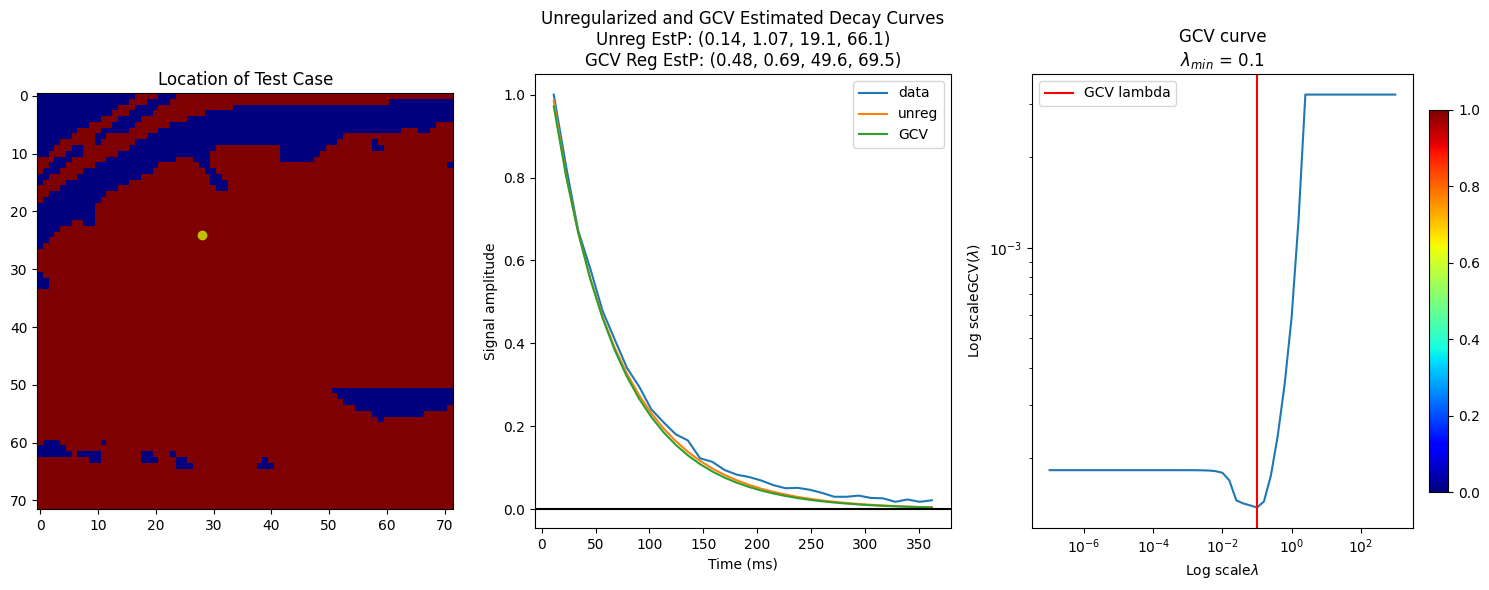

In [7]:
test_xPoint = int(n_hori/10*4)
test_yPoint = int(n_vert/3)
test_data = I_normalized[test_xPoint, test_yPoint, :]   #[125,75,:]
lam, GCV_curve = GCV_lambda_brain(test_data, lambdas)
c1n, c2n,T21n,T22n = estimate_NLLS_brain(test_data, post_normalize = False)
c1g, c2g,T21g,T22g = estimate_NLLS_brain(test_data, lam=lam, post_normalize = False)
fig, ax = plt.subplots(1,3, tight_layout=True, figsize=(15,6))
unR_pList = ', '.join(str(x) for x in (round(c1n,2), round(c2n,2), round(T21n,1), round(T22n,1)))
GCV_pList = ', '.join(str(x) for x in (round(c1g,2), round(c2g,2), round(T21g,1), round(T22g,1)))
ax[1].plot(tdata_brain, test_data, label='data')
ax[1].plot(tdata_brain, G(tdata_brain, c1n, c2n, T21n, T22n), label='unreg')
ax[1].plot(tdata_brain, G(tdata_brain, c1g, c2g, T21g, T22g), label='GCV')
ax[1].legend()
ax[1].axhline(y=0, color='k')
ax[1].set_ylabel('Signal amplitude')
ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Unregularized and GCV Estimated Decay Curves' +
                '\nUnreg EstP: (' + unR_pList + ')' +
                '\nGCV Reg EstP: (' + GCV_pList + ')')

ax[2].loglog(lambdas, GCV_curve)
ax[2].axvline(x=lam, color='r', label='GCV lambda')
ax[2].legend()
ax[2].set_ylabel('Log scale' + 'GCV(' + r'$\lambda$' + ')')
ax[2].set_xlabel('Log scale' + r'$\lambda$')
ax[2].set_title('GCV curve' + 
                '\n' + r'$\lambda_{min}$' + ' = ' + str(round(lam,2)))

imc1 = ax[0].imshow(I_normalized[:, :, 0], cmap = 'jet')
imc2 = ax[0].scatter(test_xPoint,test_yPoint, color='y')
ax[0].set_title('Location of Test Case')
# ax[0].legend()
fig.colorbar(imc1, ax=ax[2], fraction=0.046, pad=0.04)

plt.show()

### Reference MWF

Text(0.5, 0, 'Myelin Water Fraction')

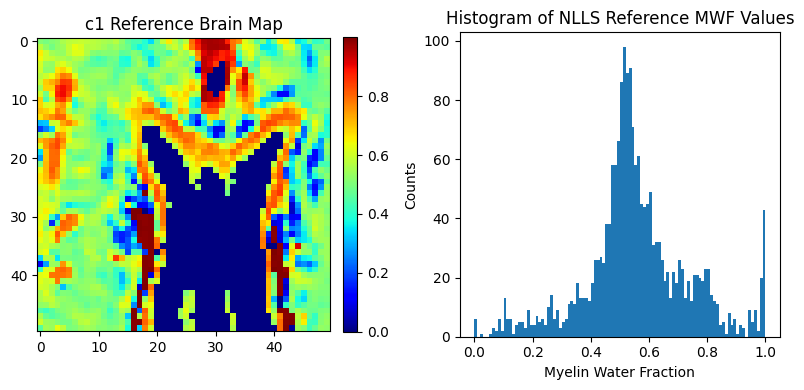

In [8]:
fig, ax = plt.subplots(1,2, figsize=(8,4),tight_layout=True)
imc1 = ax[0].imshow(c1_ref, cmap = 'jet')
ax[0].set_title('c1 Reference Brain Map')
fig.colorbar(imc1,ax=ax[0],fraction=0.046, pad=0.04)

hh = ax[1].hist(c1_ref[c1_ref>0].ravel(), 100, density=False)
ax[1].set_title('Histogram of NLLS Reference MWF Values')
ax[1].set_ylabel('Counts')
ax[1].set_xlabel('Myelin Water Fraction')

### Calculating SNR of a Brain Region

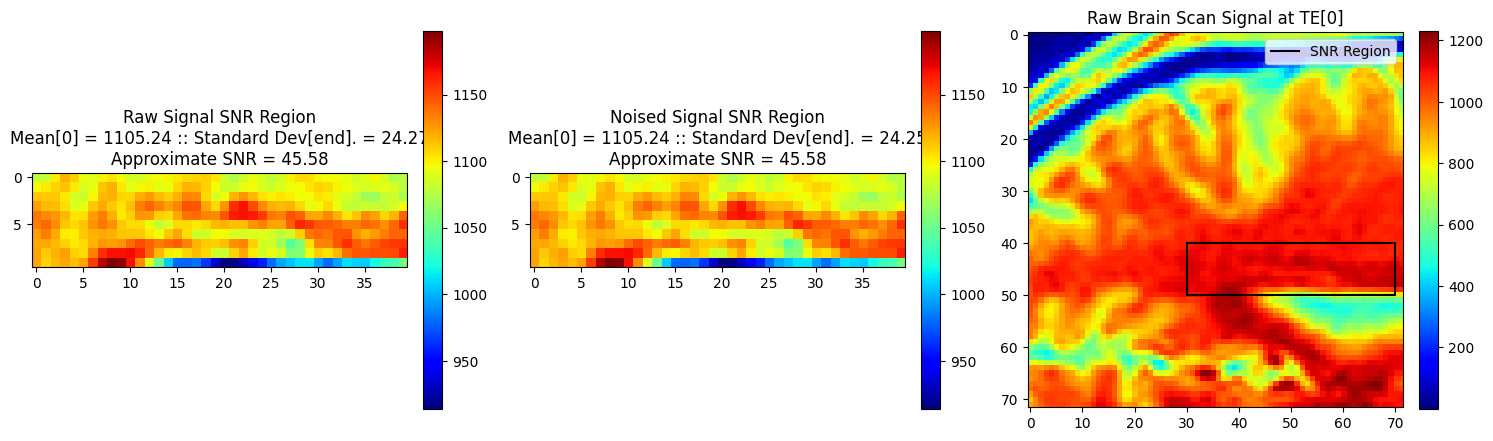

In [9]:
#Unnoised brain SNR calculation
SNR_regionZero = I_raw[vert1:vert2, hori1:hori2, 0]
SNR_regionZero_mean = np.mean(SNR_regionZero)

SNR_regionEnd = I_raw[vert1:vert2, hori1:hori2, -3:]
SNR_regionEnd_std = np.std(SNR_regionEnd)

brainSNR_raw = round(calculate_brain_SNR(I_raw,noiseRegion),2)

#Noised brain SNR calculation
nSNR_regionZero = I_noised[vert1:vert2, hori1:hori2, 0]
nSNR_regionZero_mean = np.mean(nSNR_regionZero)

nSNR_regionEnd = I_noised[vert1:vert2, hori1:hori2, -3:-1]
nSNR_regionEnd_std = np.std(nSNR_regionEnd)

brainSNR_noise = round(calculate_brain_SNR(I_noised,noiseRegion),2)

#Figures to display noise
fig, ax = plt.subplots(1,3,figsize=(15,6),tight_layout=True)

imc1 = ax[0].imshow(SNR_regionZero, cmap = 'jet')
ax[0].set_title('Raw Signal SNR Region' +
                '\nMean[0] = ' + str(round(SNR_regionZero_mean,2)) + ' :: Standard Dev[end]. = ' + str(round(SNR_regionEnd_std,2)) +
                '\nApproximate SNR = ' + str(brainSNR_raw) )
fig.colorbar(imc1, ax=ax[0], fraction=0.046, pad=0.04)

imc2 = ax[1].imshow(nSNR_regionZero, cmap = 'jet')
ax[1].set_title('Noised Signal SNR Region' +
                '\nMean[0] = ' + str(round(nSNR_regionZero_mean,2)) + ' :: Standard Dev[end]. = ' + str(round(nSNR_regionEnd_std,2)) +
                '\nApproximate SNR = ' + str(brainSNR_noise) )
fig.colorbar(imc2, ax=ax[1], fraction=0.046, pad=0.04)

imc3 = ax[2].imshow(I_raw[:, :, 0], cmap = 'jet')
ax[2].set_title('Raw Brain Scan Signal at TE[0]')
ax[2].plot(hBox,vBox, color='k', label = "SNR Region")
ax[2].legend()
fig.colorbar(imc3, ax=ax[2], fraction=0.046, pad=0.04)





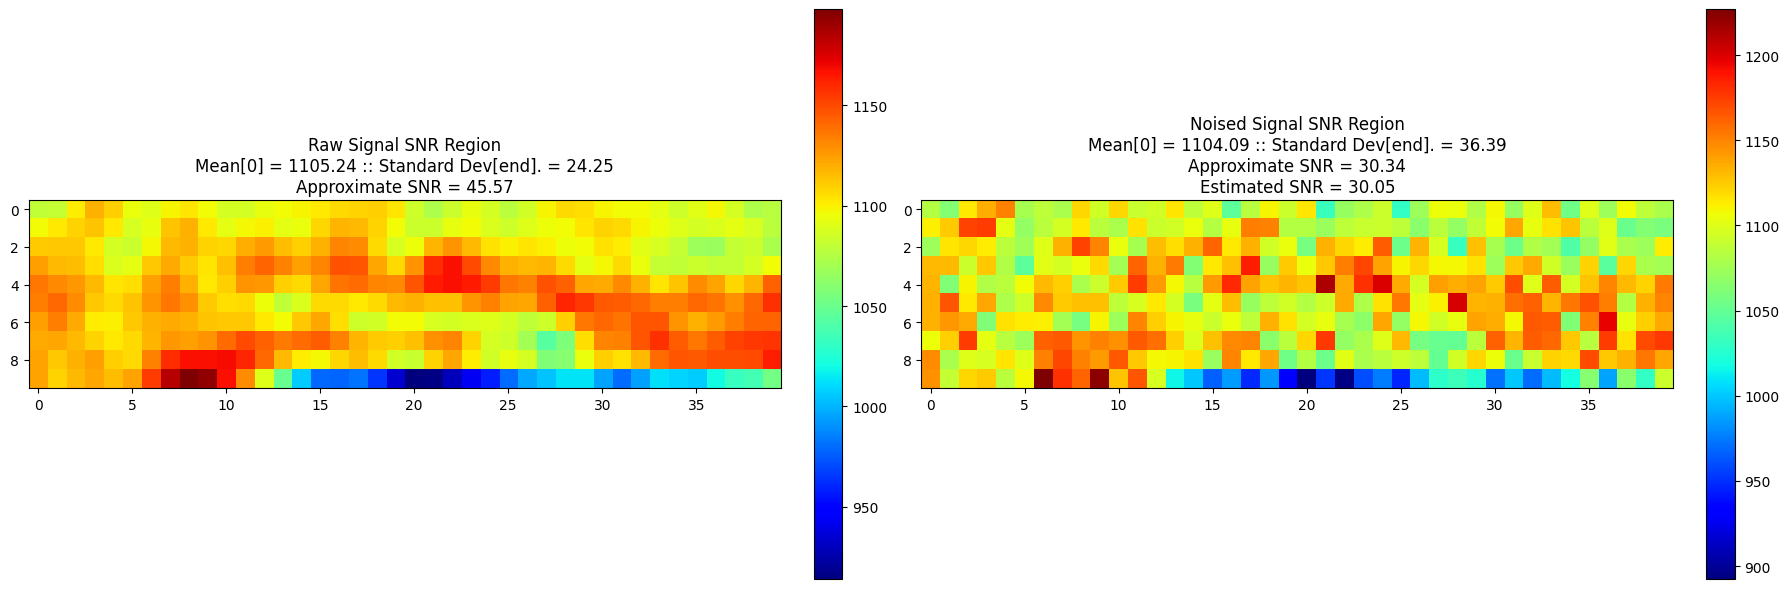

In [10]:
#Evaluating noise per pixel by accounting for each pixel

rawZone = I_raw[vert1:vert2, hori1:hori2, :]

SNR_regionZero = rawZone[:, :, 0]
SNR_regionZero_mean = np.mean(SNR_regionZero)
SNR_regionEnd = rawZone[:, :, -1]
SNR_regionEnd_std = np.std(SNR_regionEnd)
approx_brainSNR = round(SNR_regionZero_mean/SNR_regionEnd_std,2)

rawNoise = 0
rawNoised = np.zeros(rawZone.shape)

for i_hori in range(rawZone.shape[0]):
    for i_vert in range(rawZone.shape[1]):
        underlying = rawZone[i_hori, i_vert, :]
        max_signal = underlying[0]
        brain_noise_sd = max_signal/SNR_brain
        rawNoise += brain_noise_sd**2
        data = underlying + np.random.normal(0, brain_noise_sd, len(underlying))
        rawNoised[i_hori,i_vert,:] = data

numZone = rawZone.shape[0]*rawZone.shape[1]
estNoiseStd = ((SNR_regionEnd_std**2*numZone + rawNoise)/numZone)**(1/2)
estSNR = SNR_regionZero_mean/estNoiseStd

nSNR_regionZero = rawNoised[:, :, 0]
nSNR_regionZero_mean = np.mean(nSNR_regionZero)
nSNR_regionEnd = rawNoised[:, :, n_elements_brain-1]
nSNR_regionEnd_std = np.std(nSNR_regionEnd)
napprox_brainSNR = round(nSNR_regionZero_mean/nSNR_regionEnd_std,2)


fig, ax = plt.subplots(1,2,figsize=(18,6),tight_layout=True)

imc1 = ax[0].imshow(SNR_regionZero, cmap = 'jet')
ax[0].set_title('Raw Signal SNR Region' +
                '\nMean[0] = ' + str(round(SNR_regionZero_mean,2)) + ' :: Standard Dev[end]. = ' + str(round(SNR_regionEnd_std,2)) +
                '\nApproximate SNR = ' + str(approx_brainSNR) )
fig.colorbar(imc1, ax=ax[0], fraction=0.046, pad=0.04)

imc2 = ax[1].imshow(nSNR_regionZero, cmap = 'jet')
ax[1].set_title('Noised Signal SNR Region' +
                '\nMean[0] = ' + str(round(nSNR_regionZero_mean,2)) + ' :: Standard Dev[end]. = ' + str(round(nSNR_regionEnd_std,2)) +
                '\nApproximate SNR = ' + str(napprox_brainSNR) +
                '\nEstimated SNR = ' + str(round(estSNR,2)))
fig.colorbar(imc2, ax=ax[1], fraction=0.046, pad=0.04)

100%|██████████| 72/72 [00:00<00:00, 392.41it/s]


SNR mean: 125.35552062111985


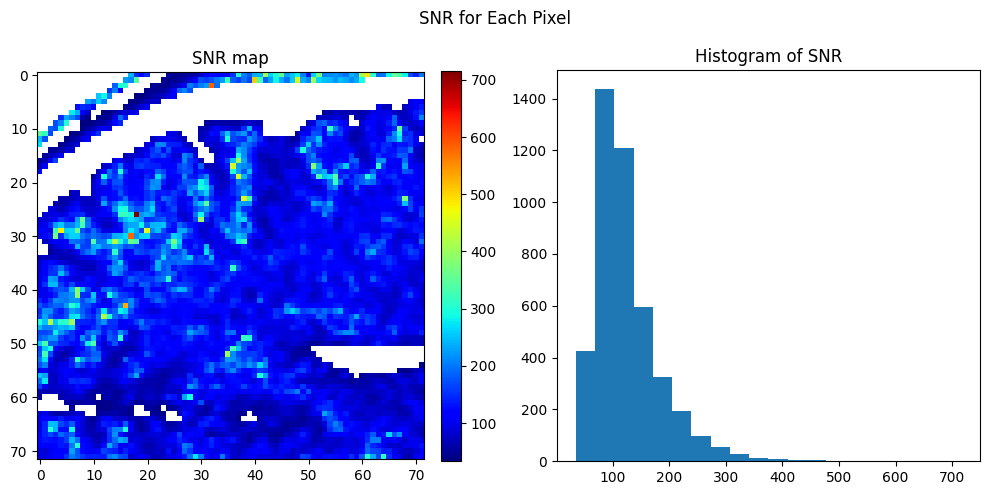

In [11]:
#Show a map of SNR in the image
brain_SNR_map = np.zeros((n_hori, n_vert))
for i_hori in trange(n_hori):
    for i_vert in range(n_vert):
        data = I_masked[i_hori,i_vert,:]
        if data[0] > 0:
            signal_end = data[(n_elements_brain-10):]
            
            brain_noise_sd = np.std(signal_end)
            brain_SNR_temp = data[0]/brain_noise_sd
            brain_SNR_map[i_hori, i_vert] = brain_SNR_temp
        else:
            brain_SNR_map[i_hori, i_vert] = None


fig, ax = plt.subplots(1, 2, figsize=(10,5),tight_layout=True)
fig.suptitle("SNR for Each Pixel")
imc1 = ax[0].imshow(brain_SNR_map, cmap = 'jet')#, norm=mpl.colors.LogNorm())
ax[0].set_title('SNR map')
n, bins, patches = ax[1].hist(np.reshape(brain_SNR_map[brain_SNR_map>0],-1), bins=20)
bincenters = 0.5*(bins[1:]+bins[:-1])
#print(bincenters)
print('SNR mean:',np.mean(brain_SNR_map[brain_SNR_map>0]))
ax[1].set_title('Histogram of SNR')
fig.colorbar(imc1,ax=ax[0],fraction=0.046, pad=0.04)
plt.show()

C:\Users\griff\AppData\Local\Temp\ipykernel_13328\3173652052.py:85: RuntimeWarning: invalid value encountered in double_scalars
  addSD = (sigRef**2/SNR_desired**2 - initSD**2)**(1/2)


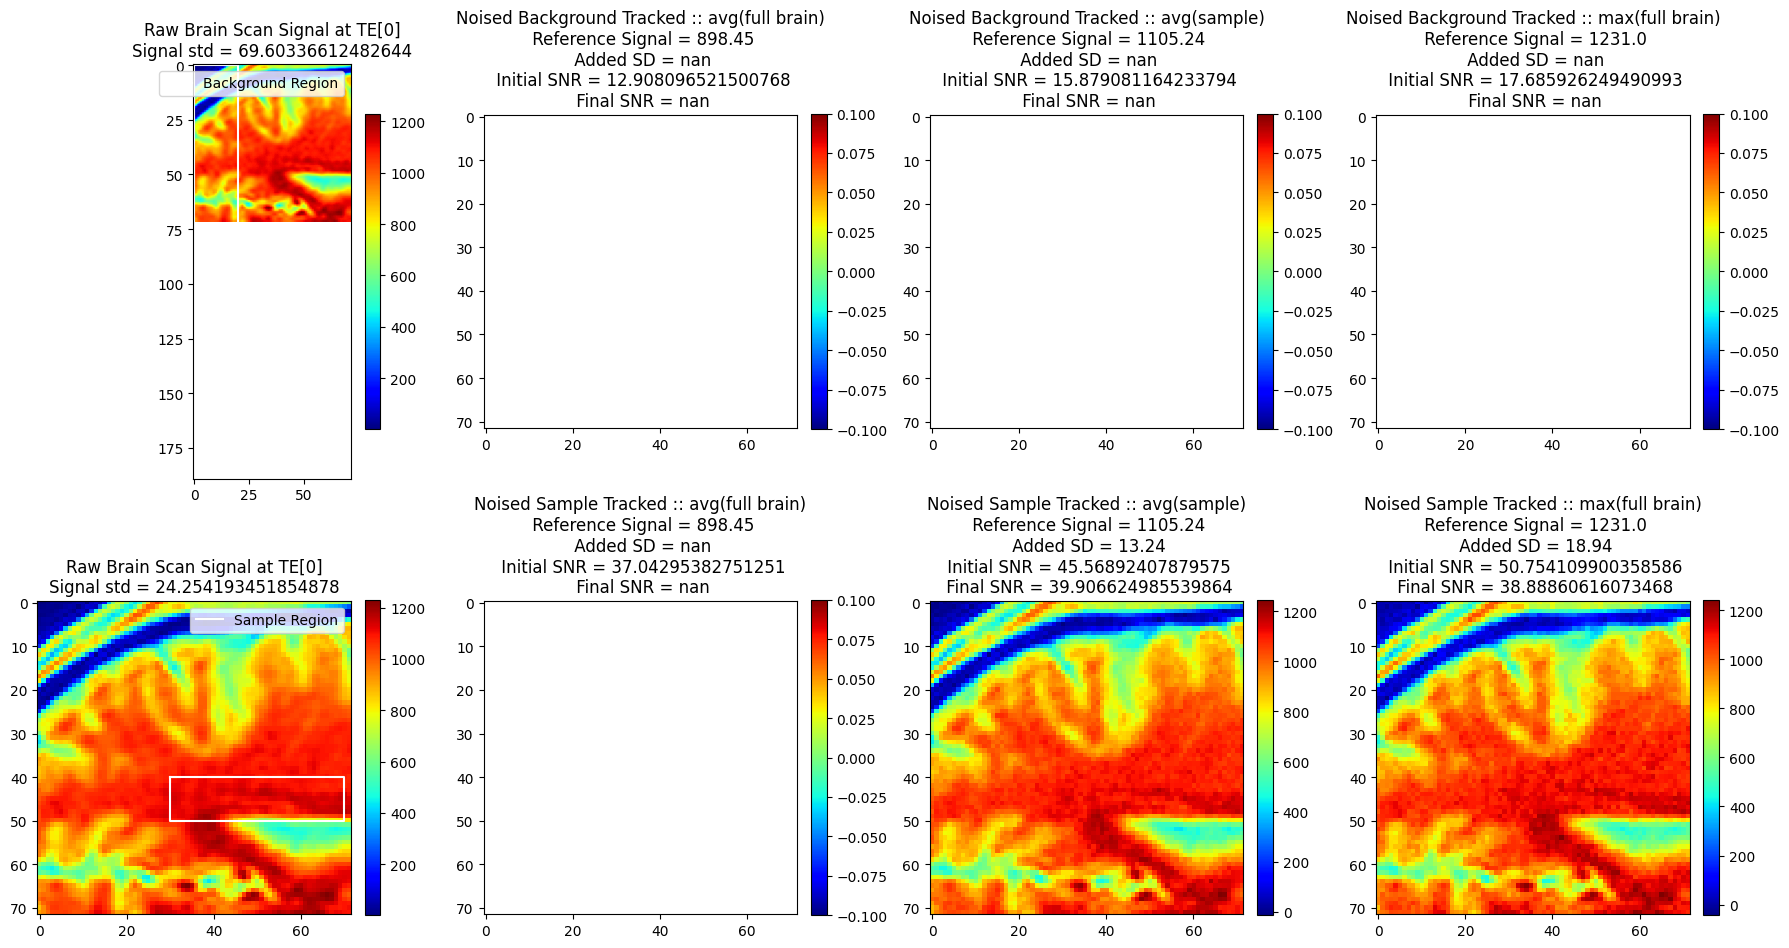

In [12]:
#Regions: (v1, v2, h1, h2)
#White Matter = (60, 125, 100, 115)
#Ventricles = (108, 116, 86, 93)

bg_v1 = 0
bg_v2 = 180
bg_h1 = 0
bg_h2 = 20
bgvBox = (bg_v1, bg_v1, bg_v2, bg_v2, bg_v1)
bghBox = (bg_h1, bg_h2, bg_h2, bg_h1, bg_h1)

bg_region_end =  I_raw[bg_v1:bg_v2, bg_h1:bg_h2, -1]
bg_sd = np.std(bg_region_end)

sampleRegion = I_raw[vert1:vert2, hori1:hori2, 0]
sampleRegionEnd = I_raw[vert1:vert2, hori1:hori2, -1]
sample_sd = np.std(sampleRegionEnd)
good_index = (I_raw[:,:,0] >100)
fullRegion = I_raw[:,:,0][good_index]

avgSigFull = np.mean(fullRegion)
avgSigReg = np.mean(sampleRegion)
maxSignal = np.max(I_raw[:,:,0])

sigMat = np.array([avgSigFull, avgSigReg, maxSignal])

SNR_init_bg = sigMat/bg_sd
SNR_init_s = sigMat/sample_sd

opt_aSF_bg, add_sd_00 = add_noise_brain_alt(I_raw, SNR_brain, sigMat[0], bg_sd)
opt_aSR_bg, add_sd_01 = add_noise_brain_alt(I_raw, SNR_brain, sigMat[1], bg_sd)
opt_mS_bg, add_sd_02 = add_noise_brain_alt(I_raw, SNR_brain, sigMat[2], bg_sd)

opt_aSF_bg_sd = np.std(opt_aSF_bg[bg_v1:bg_v2, bg_h1:bg_h2, n_elements_brain-1])
opt_aSR_bg_sd = np.std(opt_aSR_bg[bg_v1:bg_v2, bg_h1:bg_h2, n_elements_brain-1])
opt_mS_bg_sd = np.std(opt_mS_bg[bg_v1:bg_v2, bg_h1:bg_h2, n_elements_brain-1])

sig_bgSD = [opt_aSF_bg_sd, opt_aSR_bg_sd, opt_mS_bg_sd]

SNR_final_bg = sigMat/sig_bgSD


opt_aSF_s, add_sd_10 = add_noise_brain_alt(I_raw, SNR_brain, sigMat[0], sample_sd)
opt_aSR_s, add_sd_11 = add_noise_brain_alt(I_raw, SNR_brain, sigMat[1], sample_sd)
opt_mS_s, add_sd_12 = add_noise_brain_alt(I_raw, SNR_brain, sigMat[2], sample_sd)

opt_aSF_s_sd = np.std(opt_aSF_s[vert1:vert2, hori1:hori2, n_elements_brain-1])
opt_aSR_s_sd = np.std(opt_aSR_s[vert1:vert2, hori1:hori2, n_elements_brain-1])
opt_mS_s_sd = np.std(opt_mS_s[vert1:vert2, hori1:hori2, n_elements_brain-1])

sig_sSD = [opt_aSF_s_sd, opt_aSR_s_sd, opt_mS_s_sd]

SNR_final_s = sigMat/sig_sSD


fig, ax = plt.subplots(2,4,figsize=(18,10),tight_layout=True)

im00 = ax[0,0].imshow(I_raw[:, :, 0], cmap = 'jet')
ax[0,0].set_title('Raw Brain Scan Signal at TE[0]' + 
                    '\nSignal std = ' + str(bg_sd))
ax[0,0].plot(bghBox,bgvBox, color='w', label = "Background Region")
ax[0,0].legend()
fig.colorbar(im00, ax=ax[0,0], fraction=0.046, pad=0.04)

im10 = ax[1,0].imshow(I_raw[:, :, 0], cmap = 'jet')
ax[1,0].set_title('Raw Brain Scan Signal at TE[0]' + 
                    '\nSignal std = ' + str(sample_sd))
ax[1,0].plot(hBox,vBox, color='w', label = "Sample Region")
ax[1,0].legend()
fig.colorbar(im10, ax=ax[1,0], fraction=0.046, pad=0.04)

im01 = ax[0,1].imshow(opt_aSF_bg[:,:,0], cmap = 'jet')
ax[0,1].set_title('Noised Background Tracked :: avg(full brain)' +
                    '\n Reference Signal = ' + str(round(sigMat[0],2)) +
                    '\n Added SD = ' + str(round(add_sd_00,2)) +
                    '\n Initial SNR = ' + str(SNR_init_bg[0]) +
                    '\n Final SNR = ' + str(SNR_final_bg[0]))
fig.colorbar(im01, ax=ax[0,1], fraction=0.046, pad=0.04)

im11 = ax[1,1].imshow(opt_aSF_s[:,:,0], cmap = 'jet')
ax[1,1].set_title('Noised Sample Tracked :: avg(full brain)' +
                    '\n Reference Signal = ' + str(round(sigMat[0],2)) +
                    '\n Added SD = ' + str(round(add_sd_10,2)) +
                    '\n Initial SNR = ' + str(SNR_init_s[0]) +
                    '\n Final SNR = ' + str(SNR_final_s[0]))
fig.colorbar(im11, ax=ax[1,1], fraction=0.046, pad=0.04)

im02 = ax[0,2].imshow(opt_aSR_bg[:,:,0], cmap = 'jet')
ax[0,2].set_title('Noised Background Tracked :: avg(sample)' +
                    '\n Reference Signal = ' + str(round(sigMat[1],2)) +
                    '\n Added SD = ' + str(round(add_sd_01,2)) +
                    '\n Initial SNR = ' + str(SNR_init_bg[1]) +
                    '\n Final SNR = ' + str(SNR_final_bg[1]))
fig.colorbar(im02, ax=ax[0,2], fraction=0.046, pad=0.04)

im12 = ax[1,2].imshow(opt_aSR_s[:,:,0], cmap = 'jet')
ax[1,2].set_title('Noised Sample Tracked :: avg(sample)' +
                    '\n Reference Signal = ' + str(round(sigMat[1],2)) +
                    '\n Added SD = ' + str(round(add_sd_11,2)) +
                    '\n Initial SNR = ' + str(SNR_init_s[1]) +
                    '\n Final SNR = ' + str(SNR_final_s[1]))
fig.colorbar(im12, ax=ax[1,2], fraction=0.046, pad=0.04)

im03 = ax[0,3].imshow(opt_mS_bg[:,:,0], cmap = 'jet')
ax[0,3].set_title('Noised Background Tracked :: max(full brain)' +
                    '\n Reference Signal = ' + str(round(sigMat[2],2)) +
                    '\n Added SD = ' + str(round(add_sd_02,2)) +
                    '\n Initial SNR = ' + str(SNR_init_bg[2]) +
                    '\n Final SNR = ' + str(SNR_final_bg[2]))
fig.colorbar(im03, ax=ax[0,3], fraction=0.046, pad=0.04)

im13 = ax[1,3].imshow(opt_mS_s[:,:,0], cmap = 'jet')
ax[1,3].set_title('Noised Sample Tracked :: max(full brain)' +
                    '\n Reference Signal = ' + str(round(sigMat[2],2)) +
                    '\n Added SD = ' + str(round(add_sd_12,2)) +
                    '\n Initial SNR = ' + str(SNR_init_s[2]) +
                    '\n Final SNR = ' + str(SNR_final_s[2]))
fig.colorbar(im13, ax=ax[1,3], fraction=0.046, pad=0.04)


plt.show()

### KMeans Regions

Text(0, 0.5, 'Within Cluster Square Sum (WSS)')

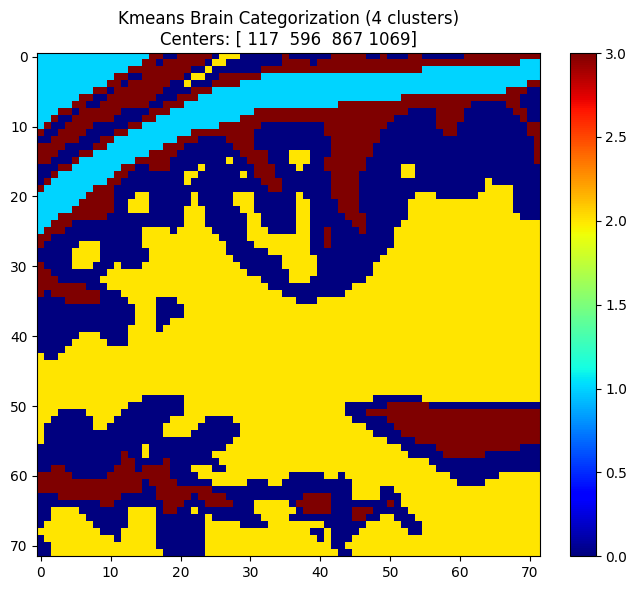

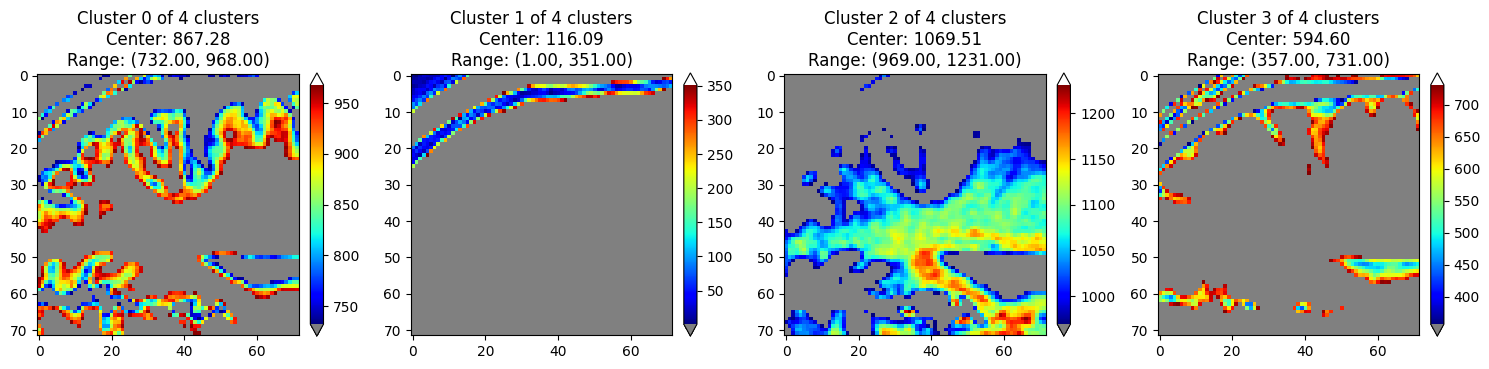

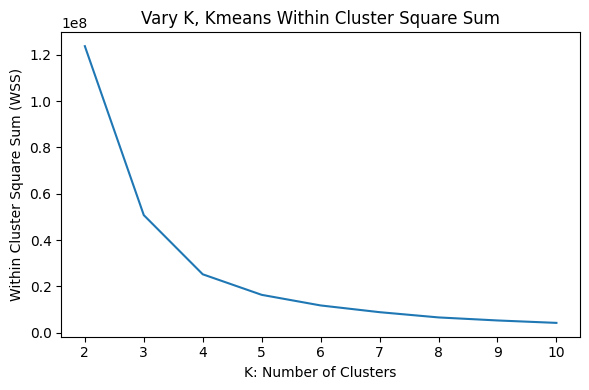

In [13]:
I_raw_linear = np.reshape(I_raw[:,:,0],(-1,1))

num_clusters = 4

kmeans = KMeans(n_clusters = num_clusters).fit(I_raw_linear)

kmeans_return = kmeans.labels_
assert(len(set(kmeans_return))==num_clusters)
kmeans_centers = np.array(kmeans.cluster_centers_)
assert(len(kmeans_centers)==num_clusters)
kmeans_rebuilt = np.reshape(kmeans_return,I_raw[:,:,0].shape)

rounded_centers = kmeans_centers.astype(int)
rounded_centers = np.reshape(rounded_centers,(1,-1))
rounded_centers.sort()
centers_List = ', '.join(str(x) for x in rounded_centers)

fig, ax = plt.subplots(figsize=(8,6),tight_layout=True)
imc1 = ax.imshow(kmeans_rebuilt, cmap = 'jet')
ax.set_title("Kmeans Brain Categorization (" + str(num_clusters)+ " clusters)" +
            "\nCenters: "+ centers_List)
fig.colorbar(imc1, fraction=0.046, pad=0.04)

fig, ax = plt.subplots(1,num_clusters,figsize=(15,6),tight_layout=True)
for k in range(num_clusters):
    cmap = plt.get_cmap('jet').copy()
    cmap.set_extremes(under='gray', over='white')
    imc1 = ax[k].imshow(I_raw[:,:,0]*(kmeans_rebuilt==k), cmap = cmap, vmin = np.min(I_raw_linear[kmeans_return==k]), vmax = np.max(I_raw_linear[kmeans_return==k]))
    ax[k].set_title("Cluster " + str(k) + " of " + str(num_clusters)+ " clusters" +
            "\nCenter: {:.2f}".format(np.mean(I_raw_linear[kmeans_return==k])) +
            "\nRange: ({:.2f}, {:.2f})".format(np.min(I_raw_linear[kmeans_return==k]),np.max(I_raw_linear[kmeans_return==k])))
    fig.colorbar(imc1, ax=ax[k], fraction=0.046, pad=0.04, extend = "both")


def calculate_WSS(data,data_categories,centers):
    num_clusters = centers.shape[0]

    WSS = 0
    for i in range(num_clusters):
        category_mat = (data_categories==i)
        WSS += np.sum((data - centers[i])**2 * category_mat)

    return WSS

optK_WSS = np.zeros((9,1))
for i in range(0,9):
    kmeans = KMeans(n_clusters = i+2).fit(I_raw_linear)

    kmeans_return = kmeans.labels_
    kmeans_centers = kmeans.cluster_centers_
    kmeans_rebuilt = np.reshape(kmeans_return,I_raw[:,:,0].shape)

    optK_WSS[i] = calculate_WSS(I_raw[:,:,0],kmeans_rebuilt,kmeans_centers)

fig, ax = plt.subplots(figsize=(6,4),tight_layout=True)
ax.plot(np.arange(2,11,1),optK_WSS)
ax.set_title("Vary K, Kmeans Within Cluster Square Sum")
ax.set_xlabel("K: Number of Clusters")
ax.set_ylabel("Within Cluster Square Sum (WSS)")



# Processing and Images of Data with the NESMA Filter

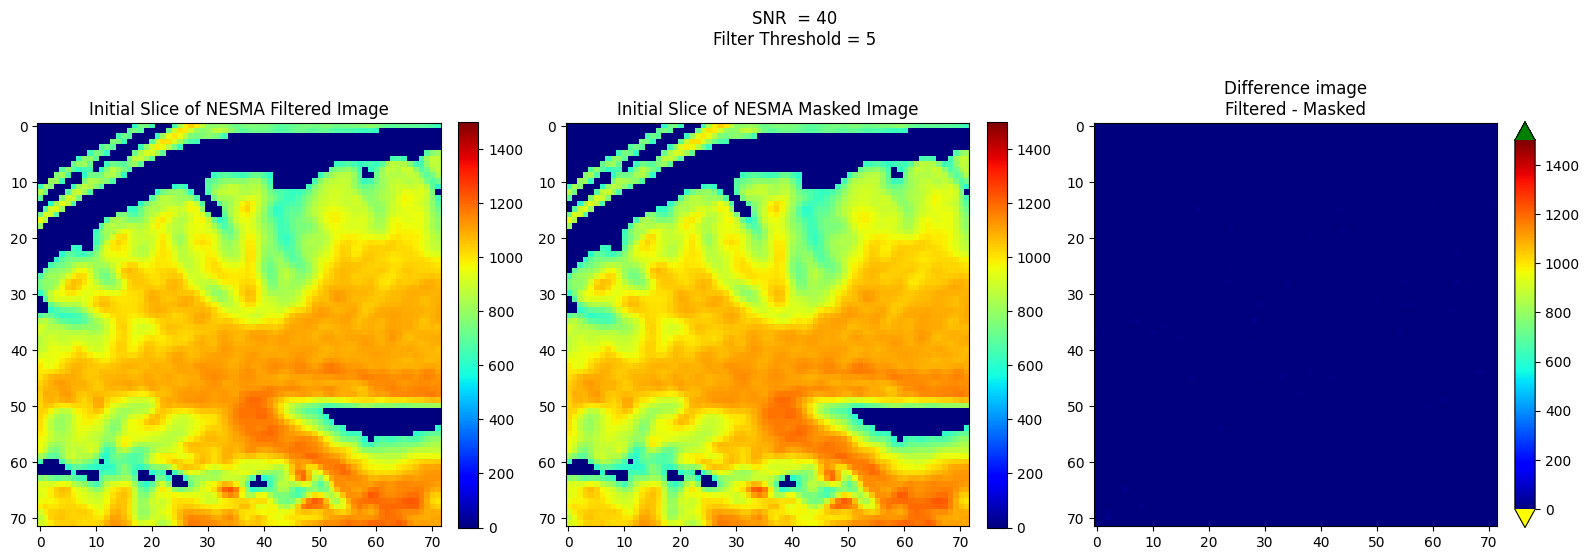

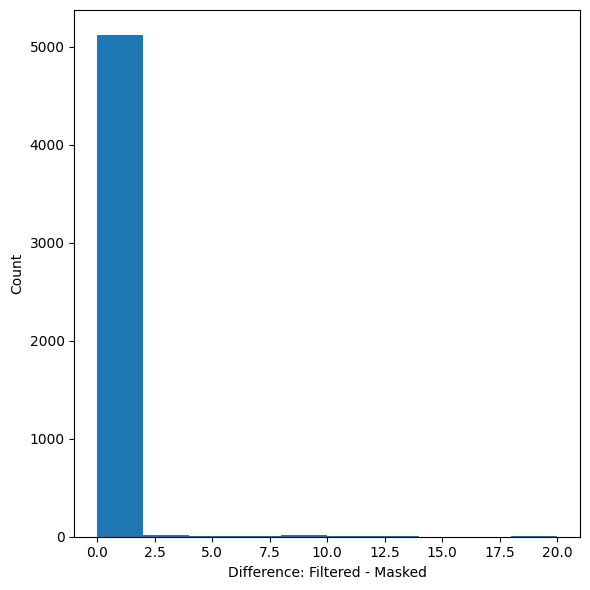

In [14]:
if apply_filter:
    signal_strength_filtered = I_filtered[:,:,0]
    signal_strength_masked = I_masked[:,:,0]
    fig, ax = plt.subplots(1,3, figsize=(16,6),tight_layout=True)
    cmap = plt.get_cmap('jet').copy()
    cmap.set_extremes(under='yellow', over='green')
    imc1 = ax[0].imshow(signal_strength_filtered, cmap = 'jet', vmin = 0, vmax = 1500)
    imc1 = ax[1].imshow(signal_strength_masked, cmap = 'jet', vmin = 0, vmax = 1500)
    imc2 = ax[2].imshow(signal_strength_filtered - signal_strength_masked, cmap = cmap, vmin = 0, vmax = 1500)
    ax[0].set_title('Initial Slice of NESMA Filtered Image')
    ax[1].set_title('Initial Slice of NESMA Masked Image')
    ax[2].set_title('Difference image' +
                    '\nFiltered - Masked')
    fig.colorbar(imc1,ax=ax[0],fraction=0.046, pad=0.04)
    fig.colorbar(imc1,ax=ax[1],fraction=0.046, pad=0.04)
    fig.colorbar(imc2,ax=ax[2],fraction=0.046, pad=0.04, extend = "both")
    fig.suptitle("SNR  = " + str(SNR_brain) + '\nFilter Threshold = {:.0f}'.format(thresh))

    plt.show()

    linearized_diff = np.reshape(signal_strength_filtered - signal_strength_masked,-1)
    fig = plt.figure(figsize=(6,6),tight_layout=True)
    plt.hist(x = (linearized_diff))
    plt.xlabel('Difference: Filtered - Masked')
    plt.ylabel('Count')
    plt.show()

In [15]:
if apply_filter:
    #Normalize the NESMA filtered data and account for Rician noise
    I_norm_NESMA = np.zeros((n_hori,n_vert,n_elements_brain))
    for i_hori in trange(n_hori):
        for i_vert in range(n_vert):
            #for i_slice in range(n_slices):
            data = I_filtered[i_hori,i_vert,:]
                #Account for the Rician noise
            signal_end = data[(n_elements_brain-10):]
            rician_correction = np.mean(signal_end)
            data_shifted = data-rician_correction
                #Normalize the data
            data_shifted = np.array(data_shifted/data_shifted[0])

            I_norm_NESMA[i_hori,i_vert,:] = data_shifted

  0%|          | 0/72 [00:00<?, ?it/s]C:\Users\griff\AppData\Local\Temp\ipykernel_13328\1905203460.py:13: RuntimeWarning: invalid value encountered in divide
  data_shifted = np.array(data_shifted/data_shifted[0])
100%|██████████| 72/72 [00:00<00:00, 301.98it/s]


100%|██████████| 72/72 [00:00<00:00, 370.02it/s]


SNR mean: 125.40332978291003


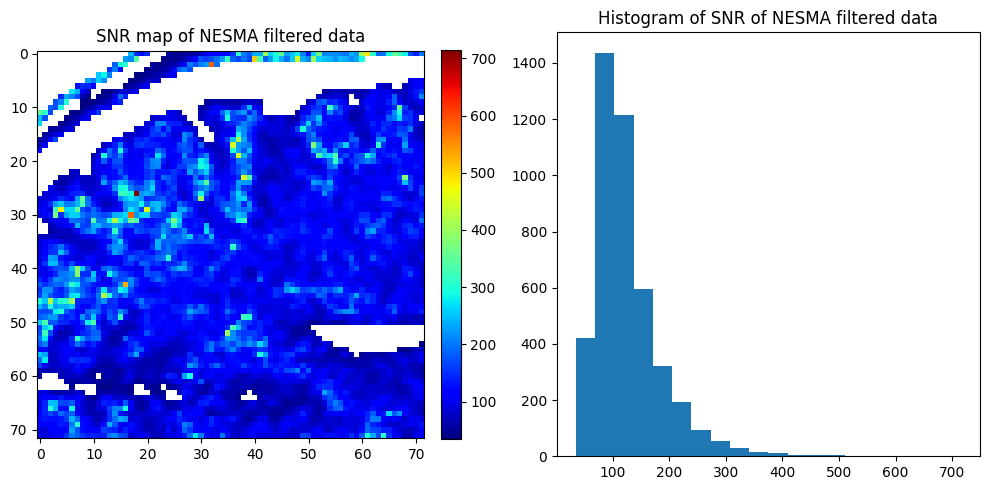

In [16]:
if apply_filter:
    brain_SNR_map_NESMA = np.zeros((n_hori, n_vert))
    for i_hori in trange(n_hori):
        for i_vert in range(n_vert):
            data = I_filtered[i_hori,i_vert,:]
            if data[0]>0:
                signal_end = data[(n_elements_brain-10):] #Accounting for noise in the data - Rician noise
                
                brain_noise_sd = np.std(signal_end)
                brain_SNR_temp = data[0]/brain_noise_sd
                brain_SNR_map_NESMA[i_hori, i_vert] = brain_SNR_temp
            else:
                brain_SNR_map_NESMA[i_hori, i_vert] = None
                
    fig, ax = plt.subplots(1, 2, figsize=(10,5),tight_layout=True)
    imc1 = ax[0].imshow(brain_SNR_map_NESMA, cmap = 'jet')
    ax[0].set_title('SNR map of NESMA filtered data')

    n, bins, patches = ax[1].hist(np.reshape(brain_SNR_map_NESMA[brain_SNR_map_NESMA>0],-1), bins=20)
    bincenters_NESMA = 0.5*(bins[1:]+bins[:-1])
    #print(bincenters_NESMA)
    print('SNR mean:',np.mean(brain_SNR_map_NESMA[brain_SNR_map_NESMA>0]))
    ax[1].set_title('Histogram of SNR of NESMA filtered data')

    fig.colorbar(imc1,ax=ax[0],fraction=0.046, pad=0.04)

    plt.show()

# Apply Unregularized NLLS to the Brain Data

In [17]:
if not load_data: parameter_maps_NLLS = create_NLLS_map(I_normalized)

100%|██████████| 72/72 [35:50<00:00, 29.87s/it]


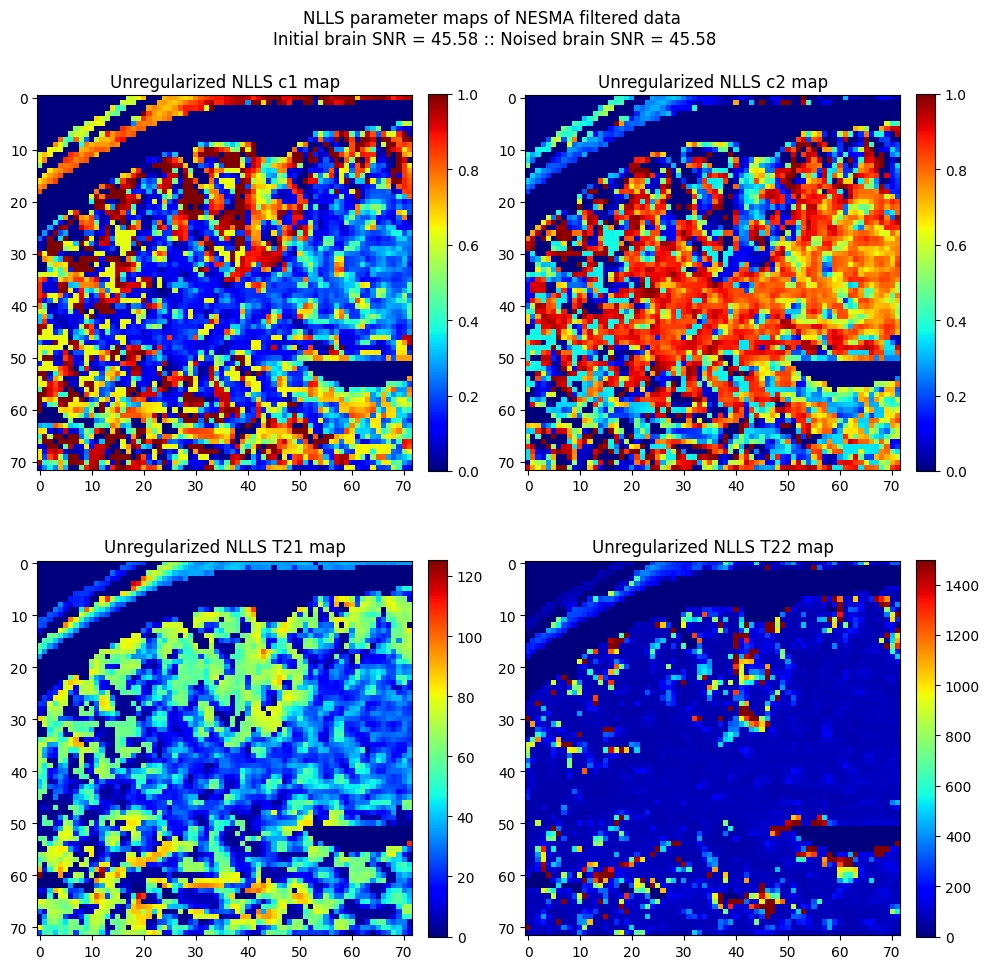

In [18]:
fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
fig.suptitle('NLLS parameter maps of NESMA filtered data \nInitial brain SNR = ' + str(brainSNR_raw) + " :: Noised brain SNR = " + str(brainSNR_noise))
imc1 = ax[0,0].imshow(parameter_maps_NLLS[:,:,0], cmap = 'jet', vmin=0, vmax=1)
ax[0,0].set_title('Unregularized NLLS c1 map')

imc2 = ax[0,1].imshow(parameter_maps_NLLS[:,:,1], cmap = 'jet', vmin=0, vmax=1)
ax[0,1].set_title('Unregularized NLLS c2 map')

imT21 = ax[1,0].imshow(parameter_maps_NLLS[:,:,2], cmap = 'jet', vmin=0)
ax[1,0].set_title('Unregularized NLLS T21 map')

imT22 = ax[1,1].imshow(parameter_maps_NLLS[:,:,3], cmap = 'jet')
ax[1,1].set_title('Unregularized NLLS T22 map')

fig.colorbar(imc1, ax=ax[0,0], fraction=0.046, pad=0.04)
fig.colorbar(imc2, ax=ax[0,1], fraction=0.046, pad=0.04)
fig.colorbar(imT21, ax=ax[1,0], fraction=0.046, pad=0.04)
fig.colorbar(imT22, ax=ax[1,1], fraction=0.046, pad=0.04)
plt.show()

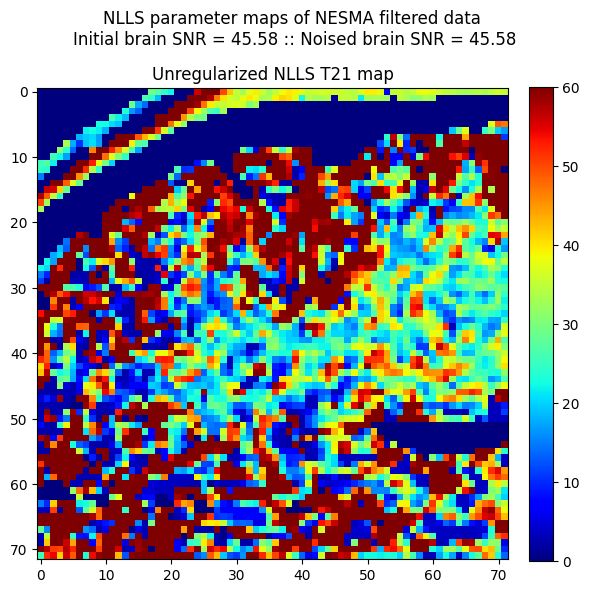

In [19]:
fig, ax = plt.subplots(1,1,figsize=(6,6),tight_layout=True)
fig.suptitle('NLLS parameter maps of NESMA filtered data \nInitial brain SNR = ' + str(brainSNR_raw) + " :: Noised brain SNR = " + str(brainSNR_noise))

imT21 = ax.imshow(parameter_maps_NLLS[:,:,2], cmap = 'jet', vmin=0, vmax = 60)
ax.set_title('Unregularized NLLS T21 map')

fig.colorbar(imT21, ax=ax, fraction=0.046, pad=0.04)

plt.show()

In [20]:
if not bounded:
    outlier_count = np.zeros((parameter_maps_NLLS.shape[-1],1))
    parameter_map_NLLS_outlierCut = np.zeros(parameter_maps_NLLS.shape)
    for iter in range(parameter_maps_NLLS.shape[-1]):
        hold = parameter_maps_NLLS[:,:,iter]
        outlier_count[iter] = np.sum(hold>upper_bound_reasonable[iter])
        parameter_map_NLLS_outlierCut[:,:,iter] = hold*(hold<upper_bound_reasonable[iter])
        
    
    fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
    fig.suptitle('Outlier Removed NLLS parameter maps of NESMA filtered data \nInitial brain SNR = ' + str(brainSNR_raw) + " :: Noised brain SNR = " + str(brainSNR_noise))
    imc1 = ax[0,0].imshow(parameter_map_NLLS_outlierCut[:,:,0], cmap = 'jet', vmin=0, vmax=1)
    ax[0,0].set_title('Unregularized NLLS c1 map' + f'\nOutliers = {outlier_count[0]}')

    imc2 = ax[0,1].imshow(parameter_map_NLLS_outlierCut[:,:,1], cmap = 'jet', vmin=0, vmax=1)
    ax[0,1].set_title('Unregularized NLLS c2 map' + f'\nOutliers = {outlier_count[1]}')

    imT21 = ax[1,0].imshow(parameter_map_NLLS_outlierCut[:,:,2], cmap = 'jet')
    ax[1,0].set_title('Unregularized NLLS T21 map' + f'\nOutliers = {outlier_count[2]}')

    imT22 = ax[1,1].imshow(parameter_map_NLLS_outlierCut[:,:,3], cmap = 'jet')
    ax[1,1].set_title('Unregularized NLLS T22 map' + f'\nOutliers = {outlier_count[3]}')

    fig.colorbar(imc1, ax=ax[0,0], fraction=0.046, pad=0.04)
    fig.colorbar(imc2, ax=ax[0,1], fraction=0.046, pad=0.04)
    fig.colorbar(imT21, ax=ax[1,0], fraction=0.046, pad=0.04)
    fig.colorbar(imT22, ax=ax[1,1], fraction=0.046, pad=0.04)
    plt.show()

In [21]:
if not bounded:
    outlier_count = np.zeros((parameter_maps_NLLS.shape[-1],1))
    parameter_map_NLLS_outlierCut = np.zeros(parameter_maps_NLLS.shape)
    for iter in range(parameter_maps_NLLS.shape[-1]):
        hold = parameter_maps_NLLS[:,:,iter]
        outlier_count[iter] = np.sum(hold>upper_bound_reasonable[iter])
        parameter_map_NLLS_outlierCut[:,:,iter] = (hold<upper_bound_reasonable[iter])
        
    
    fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
    fig.suptitle('Outliers Only NLLS parameter maps of NESMA filtered data \nInitial brain SNR = ' + str(brainSNR_raw) + " :: Noised brain SNR = " + str(brainSNR_noise))
    imc1 = ax[0,0].imshow(parameter_map_NLLS_outlierCut[:,:,0], cmap = 'jet', vmin=0, vmax=1)
    ax[0,0].set_title('Unregularized NLLS c1 map' + f'\nOutliers = {outlier_count[0]}')

    imc2 = ax[0,1].imshow(parameter_map_NLLS_outlierCut[:,:,1], cmap = 'jet', vmin=0, vmax=1)
    ax[0,1].set_title('Unregularized NLLS c2 map' + f'\nOutliers = {outlier_count[1]}')

    imT21 = ax[1,0].imshow(parameter_map_NLLS_outlierCut[:,:,2], cmap = 'jet')
    ax[1,0].set_title('Unregularized NLLS T21 map' + f'\nOutliers = {outlier_count[2]}')

    imT22 = ax[1,1].imshow(parameter_map_NLLS_outlierCut[:,:,3], cmap = 'jet')
    ax[1,1].set_title('Unregularized NLLS T22 map' + f'\nOutliers = {outlier_count[3]}')

    fig.colorbar(imc1, ax=ax[0,0], fraction=0.046, pad=0.04)
    fig.colorbar(imc2, ax=ax[0,1], fraction=0.046, pad=0.04)
    fig.colorbar(imT21, ax=ax[1,0], fraction=0.046, pad=0.04)
    fig.colorbar(imT22, ax=ax[1,1], fraction=0.046, pad=0.04)
    plt.show()

# Apply GCV Reg-NLLS to the Brain Data

In [22]:
if not load_data: parameter_maps_GCV, lambda_map_GCV = create_GCV_map(I_normalized, lambdas)

100%|██████████| 72/72 [15:57:00<00:00, 797.50s/it]   


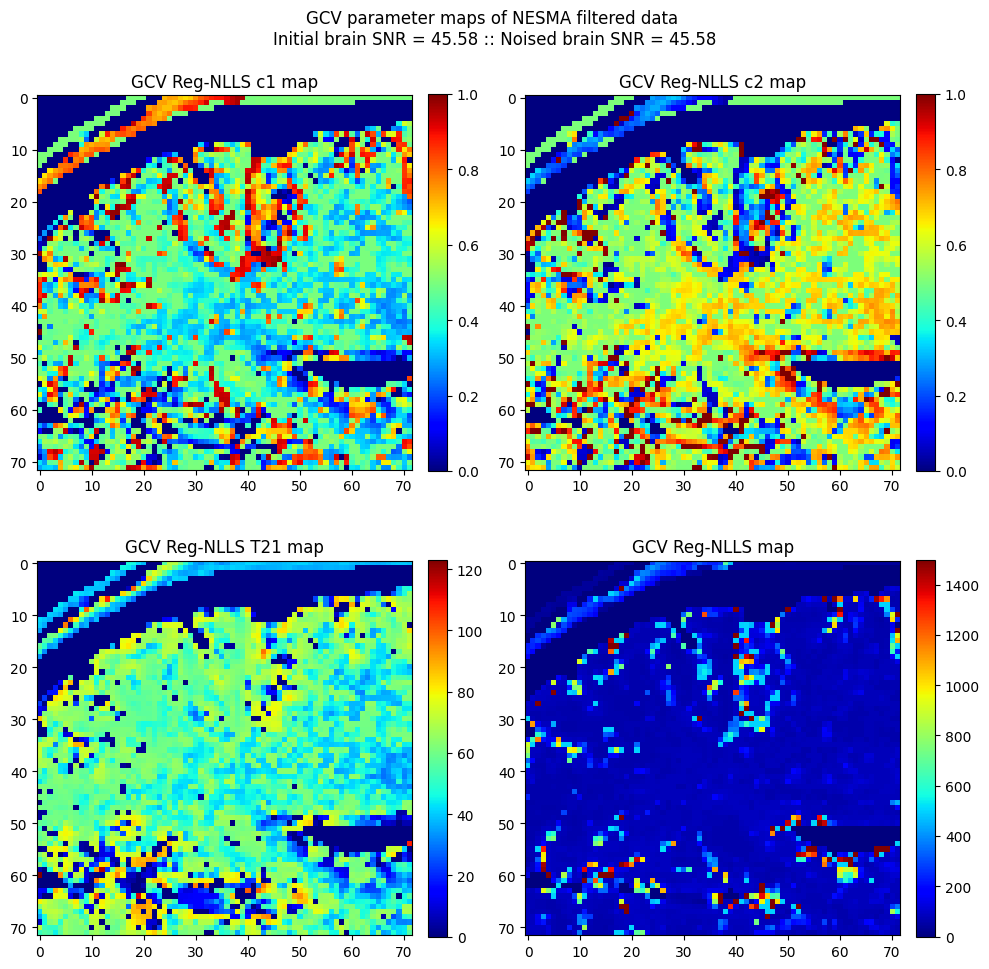

In [23]:
fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
fig.suptitle('GCV parameter maps of NESMA filtered data \nInitial brain SNR = ' + str(brainSNR_raw) + " :: Noised brain SNR = " + str(brainSNR_noise))
imc1 = ax[0,0].imshow(parameter_maps_GCV[:,:,0], cmap = 'jet', vmin=0, vmax=1)
ax[0,0].set_title('GCV Reg-NLLS c1 map')

imc2 = ax[0,1].imshow(parameter_maps_GCV[:,:,1], cmap = 'jet', vmin=0, vmax=1)
ax[0,1].set_title('GCV Reg-NLLS c2 map')

imT21 = ax[1,0].imshow(parameter_maps_GCV[:,:,2], cmap = 'jet')
ax[1,0].set_title('GCV Reg-NLLS T21 map')

imT22 = ax[1,1].imshow(parameter_maps_GCV[:,:,3], cmap = 'jet')
ax[1,1].set_title('GCV Reg-NLLS map')

fig.colorbar(imc1,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(imc2,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(imT21,ax=ax[1,0],fraction=0.046, pad=0.04)
fig.colorbar(imT22,ax=ax[1,1],fraction=0.046, pad=0.04)
plt.show()

In [24]:
if not bounded:
    outlier_count = np.zeros((parameter_maps_GCV.shape[-1],1))
    parameter_map_GCV_outlierCut = np.zeros(parameter_maps_GCV.shape)
    for iter in range(parameter_maps_GCV.shape[-1]):
        hold = parameter_maps_GCV[:,:,iter]
        outlier_count[iter] = np.sum(hold>upper_bound_reasonable[iter])
        parameter_map_GCV_outlierCut[:,:,iter] = hold*(hold<upper_bound_reasonable[iter])
        
    
    fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
    fig.suptitle('Outlier Removed GCV parameter maps of NESMA filtered data \nInitial brain SNR = ' + str(brainSNR_raw) + " :: Noised brain SNR = " + str(brainSNR_noise))
    imc1 = ax[0,0].imshow(parameter_map_GCV_outlierCut[:,:,0], cmap = 'jet', vmin=0, vmax=1)
    ax[0,0].set_title('Regularized GCV c1 map' + f'\nOutliers = {outlier_count[0]}')

    imc2 = ax[0,1].imshow(parameter_map_GCV_outlierCut[:,:,1], cmap = 'jet', vmin=0, vmax=1)
    ax[0,1].set_title('Regularized GCV c2 map' + f'\nOutliers = {outlier_count[1]}')

    imT21 = ax[1,0].imshow(parameter_map_GCV_outlierCut[:,:,2], cmap = 'jet')
    ax[1,0].set_title('Regularized GCV T21 map' + f'\nOutliers = {outlier_count[2]}')

    imT22 = ax[1,1].imshow(parameter_map_GCV_outlierCut[:,:,3], cmap = 'jet')
    ax[1,1].set_title('Regularized GCV T22 map' + f'\nOutliers = {outlier_count[3]}')

    fig.colorbar(imc1, ax=ax[0,0], fraction=0.046, pad=0.04)
    fig.colorbar(imc2, ax=ax[0,1], fraction=0.046, pad=0.04)
    fig.colorbar(imT21, ax=ax[1,0], fraction=0.046, pad=0.04)
    fig.colorbar(imT22, ax=ax[1,1], fraction=0.046, pad=0.04)
    plt.show()

In [25]:
if not bounded:
    outlier_count = np.zeros((parameter_maps_GCV.shape[-1],1))
    parameter_map_GCV_outlierCut = np.zeros(parameter_maps_GCV.shape)
    for iter in range(parameter_maps_GCV.shape[-1]):
        hold = parameter_maps_GCV[:,:,iter]
        outlier_count[iter] = np.sum(hold>upper_bound_reasonable[iter])
        parameter_map_GCV_outlierCut[:,:,iter] = (hold<upper_bound_reasonable[iter])
        
    
    fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
    fig.suptitle('Outliers Only Removed GCV parameter maps of NESMA filtered data \nInitial brain SNR = ' + str(brainSNR_raw) + " :: Noised brain SNR = " + str(brainSNR_noise))
    imc1 = ax[0,0].imshow(parameter_map_GCV_outlierCut[:,:,0], cmap = 'jet', vmin=0, vmax=1)
    ax[0,0].set_title('Regularized GCV c1 map' + f'\nOutliers = {outlier_count[0]}')

    imc2 = ax[0,1].imshow(parameter_map_GCV_outlierCut[:,:,1], cmap = 'jet', vmin=0, vmax=1)
    ax[0,1].set_title('Regularized GCV c2 map' + f'\nOutliers = {outlier_count[1]}')

    imT21 = ax[1,0].imshow(parameter_map_GCV_outlierCut[:,:,2], cmap = 'jet')
    ax[1,0].set_title('Regularized GCV T21 map' + f'\nOutliers = {outlier_count[2]}')

    imT22 = ax[1,1].imshow(parameter_map_GCV_outlierCut[:,:,3], cmap = 'jet')
    ax[1,1].set_title('Regularized GCV T22 map' + f'\nOutliers = {outlier_count[3]}')

    fig.colorbar(imc1, ax=ax[0,0], fraction=0.046, pad=0.04)
    fig.colorbar(imc2, ax=ax[0,1], fraction=0.046, pad=0.04)
    fig.colorbar(imT21, ax=ax[1,0], fraction=0.046, pad=0.04)
    fig.colorbar(imT22, ax=ax[1,1], fraction=0.046, pad=0.04)
    plt.show()

# Apply DNN Reg-NLLS to the brain data

In [26]:
# parameter_maps_DNN, lambda_map_DNN = create_DNN_map(I_normalized, all_SNR = True)

In [27]:
# fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
# fig.suptitle('DNN parameter maps of NESMA filtered data, brain SNR = %s'%(SNR_brain))
# imc1 = ax[0,0].imshow(parameter_maps_DNN[:,:,0], cmap = 'jet')
# ax[0,0].set_title('DNN Reg-NLLS c1 map')

# imc2 = ax[0,1].imshow(parameter_maps_DNN[:,:,1], cmap = 'jet')
# ax[0,1].set_title('DNN Reg-NLLS c2 map')

# imT21 = ax[1,0].imshow(parameter_maps_DNN[:,:,2], cmap = 'jet')
# ax[1,0].set_title('DNN Reg-NLLS T21 map')

# imT22 = ax[1,1].imshow(parameter_maps_DNN[:,:,3], cmap = 'jet')
# ax[1,1].set_title('DNN Reg-NLLS map')

# fig.colorbar(imc1,ax=ax[0,0],fraction=0.046, pad=0.04)
# fig.colorbar(imc2,ax=ax[0,1],fraction=0.046, pad=0.04)
# fig.colorbar(imT21,ax=ax[1,0],fraction=0.046, pad=0.04)
# fig.colorbar(imT22,ax=ax[1,1],fraction=0.046, pad=0.04)
# plt.show()

# Generate Difference Maps

In [28]:
parameter_maps_NLLS
parameter_maps_GCV

NLLS_diff = (parameter_maps_NLLS[:,:,0] - c1_ref)**2
GCV_diff = (parameter_maps_GCV[:,:,0] - c1_ref)**2

NLLS_MSD = calculate_MSD(c1_ref, parameter_maps_NLLS[:,:,0])
GCV_MSD = calculate_MSD(c1_ref, parameter_maps_GCV[:,:,0])

NLLS_MSD_map, NLLS_MSD_norm = calculate_MSD_norm(brain_ref, parameter_maps_NLLS[:,:,:])
GCV_MSD_map, GCV_MSD_norm = calculate_MSD_norm(brain_ref, parameter_maps_GCV[:,:,:])

NLLS_MSD_total = 0
GCV_MSD_total = 0
for p in range(np.size(initial_brain)): #loops through parameters of the initial brain
    NLLS_MSD_total += calculate_MSD(brain_ref[:,:,p], parameter_maps_NLLS[:,:,p])/initial_brain[p]
    GCV_MSD_total += calculate_MSD(brain_ref[:,:,p], parameter_maps_GCV[:,:,p])/initial_brain[p]

fig, ax = plt.subplots(1,3,figsize=(20,7),tight_layout=True)
fig.suptitle('Difference Maps Between Methods, NLLS and GCV' + '\nSNR = ' + str(brainSNR_noise))
imref = ax[0].imshow(c1_ref, cmap = 'jet')
ax[0].set_title('Mylin Water Fraction Reference Map')

imNLLS = ax[1].imshow(NLLS_diff, cmap = 'jet', vmin=0, vmax=np.max([NLLS_diff,GCV_diff]))
ax[1].set_title('NLLS Difference Map')
ax[1].text(10, 10, 'Mean square difference = %s'%round(NLLS_MSD,5), color='w')
# ax[1].text(10, 20, 'All Param Mean Square Difference = %s'%round(NLLS_MSD_total,5), color='w')
ax[1].text(10, 20, 'All Norm Mean Square Difference = %s'%round(NLLS_MSD_norm,5), color='w')
imGCV = ax[2].imshow(GCV_diff, cmap = 'jet', vmin=0, vmax=np.max([NLLS_diff,GCV_diff]))
ax[2].set_title('GCV Difference Map')
ax[2].text(10, 10, 'Mean square difference = %s'%round(GCV_MSD,5), color='w')
# ax[2].text(10, 20, 'All Param Mean Square Difference = %s'%round(GCV_MSD_total,5), color='w')
ax[2].text(10, 20, 'All Norm Mean Square Difference = %s'%round(GCV_MSD_norm,5), color='w')

fig.colorbar(imref,ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(imNLLS,ax=ax[1],fraction=0.046, pad=0.04)
fig.colorbar(imGCV,ax=ax[2],fraction=0.046, pad=0.04)
plt.show()

ValueError: operands could not be broadcast together with shapes (72,72) (50,50) 

# Generate Map of Oracle Lambdas

In [ ]:
# lambda_map_oracle = create_oracle_map(c1_ref, I_filtered, lambdas)

# lambda_map_oracle = np.zeros((n_hori, n_vert))
# for i_hori in trange(n_hori):
#     for i_vert in range(n_vert):
#         data = I_filtered[i_hori,i_vert,:]
#         #Check if there is signal present
#         if data[0] > 0:
#             data = data/data[0]
#             try:
#                 oracle_lam = oracle_lambda_brain(c1_ref[i_hori,i_vert],data,lambdas,0)
#                 lambda_map_oracle[i_hori,i_vert] = oracle_lam
#             except:
#                 lambda_map_oracle[i_hori,i_vert] = 0
#         #If no signal, return zero for all parameters
#         else:
#             lambda_map_oracle[i_hori,i_vert] = 0

In [ ]:
# fig, ax = plt.subplots(1,2,figsize=(21,7),tight_layout=True)
# fig.suptitle('Maps of lambda, oracle, GCV and DNN')
# imOra = ax[0].imshow(lambda_map_oracle, cmap = 'jet', norm=mpl.colors.LogNorm())
# ax[0].set_title('Oracle lambda map')

# imGCV = ax[1].imshow(lambda_map_GCV, cmap = 'jet', norm=mpl.colors.LogNorm())
# ax[1].set_title('GCV lambda map')

# fig.colorbar(imOra,ax=ax[0],fraction=0.046,pad=0.04)
# fig.colorbar(imGCV,ax=ax[1],fraction=0.046,pad=0.04)

# plt.show()

# Save Code in an hdf5 File in the Output Folder

In [ ]:
# Save a map
if not runIter and not load_data:
    with h5py.File('Brain_Output//'+ output_fileName +'.hdf5','a') as f:
        #Save a data set
        dset = f.create_dataset('NLLS_params',data=parameter_maps_NLLS)
        dset = f.create_dataset('GCV_params',data=parameter_maps_GCV)
        dset = f.create_dataset('GCV_lambdas',data=lambda_map_GCV)
        # dset = f.create_dataset('Oracle_lambdas',data=lambda_map_oracle)
        dset = f.create_dataset('Noised_data',data=I_noised)
        

# Building Repository of Brain Runs

In [ ]:
### Streamlined Run Conditions
if runIter:
    # Use the data from the first run as part of the rpo
    fileName = seriesTag + str(SNR_brain) + "_Rep_" + str(startNum)

    with h5py.File('Brain_Repo//'+ fileName +'.hdf5','a') as f:
        #Save a data set
        dset = f.create_dataset('NLLS_params',data=parameter_maps_NLLS)
        dset = f.create_dataset('GCV_params',data=parameter_maps_GCV)
        dset = f.create_dataset('GCV_lambdas',data=lambda_map_GCV)
        # dset = f.create_dataset('Oracle_lambdas',data=lambda_map_oracle)
        dset = f.create_dataset('Noised_data',data=I_noised)

    for iter in trange(iterations-1):

        fileNum = startNum + iter + 1

        fileName = seriesTag + str(SNR_brain) + "_Rep_" + str(fileNum)

        ### Generate Noise Realization
        # #Add noise to the image
        if add_noise:
            if uniform_noise:
                I_noised, added_noiseSD = add_noise_brain_uniform(I_raw, SNR_brain, noiseRegion) #adds noise uniformly to get the desired amount added
            else:
                I_noised = add_noise_brain(I_raw, SNR_brain) #perpixel addition
        else:
            I_noised = I_raw

        #  #Mask components of image with signals intended to remove
        if add_mask:
            I_masked_original = mask_data(I_raw, mask_amplitude)
            I_masked = mask_data(I_noised, mask_amplitude)
            if maintain_mask: #Ensures that the masked sections stay masked
                I_masked = I_noised*(I_masked_original!=0)
        else:
            I_masked = I_raw

        I_filtered = NESMA_filtering_3D(I_masked, txy, thresh, verbose = False)
        I_normalized = normalize_brain(I_filtered)

        ### Compute Parameter Maps
        parameter_maps_NLLS = create_NLLS_map(I_normalized)
        parameter_maps_GCV, lambda_map_GCV = create_GCV_map(I_normalized, lambdas)
        # lambda_map_oracle = create_oracle_map(c1_ref, I_filtered, lambdas)

        ### Save a map
        with h5py.File('Brain_Repo//'+ fileName +'.hdf5','a') as f:
            #Save a data set
            dset = f.create_dataset('NLLS_params',data=parameter_maps_NLLS)
            dset = f.create_dataset('GCV_params',data=parameter_maps_GCV)
            dset = f.create_dataset('GCV_lambdas',data=lambda_map_GCV)
            # dset = f.create_dataset('Oracle_lambdas',data=lambda_map_oracle)
            dset = f.create_dataset('Noised_data',data=I_noised)
    


# Load Data Sets and Process

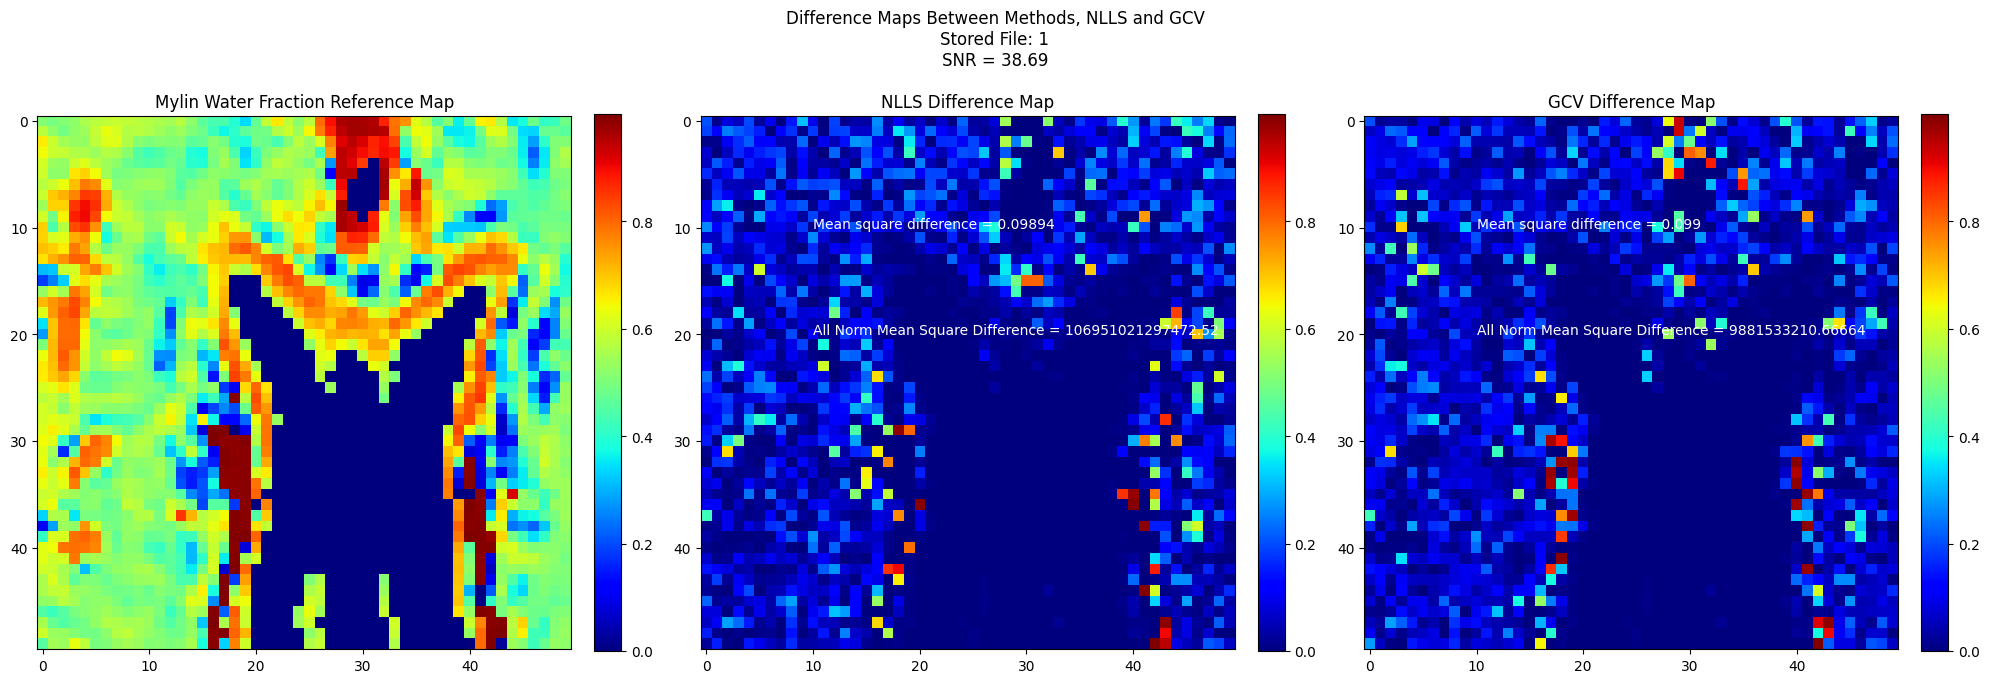

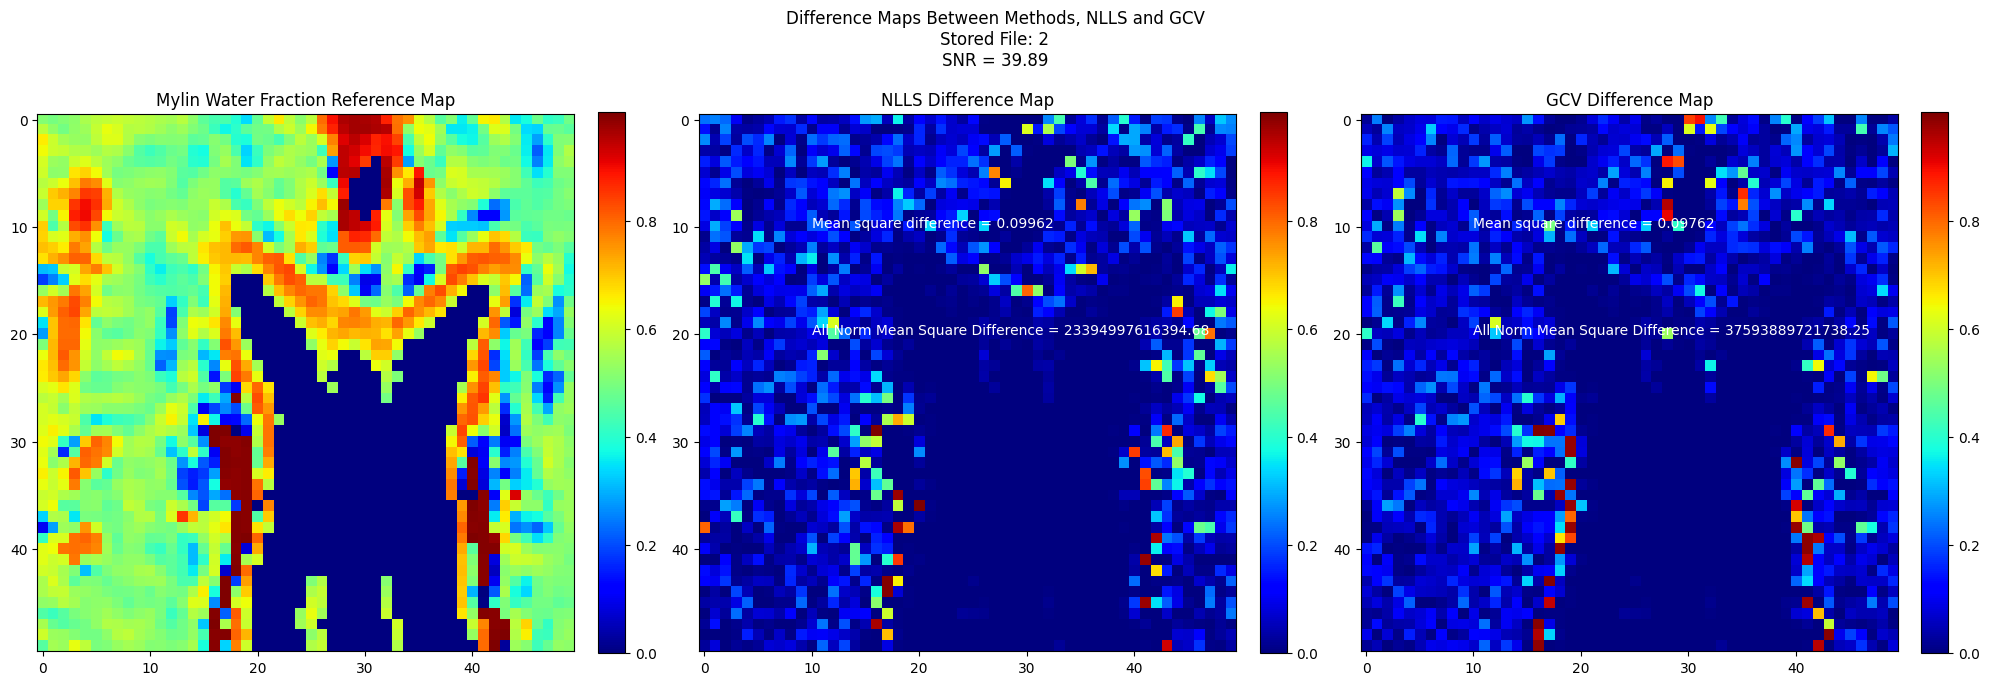

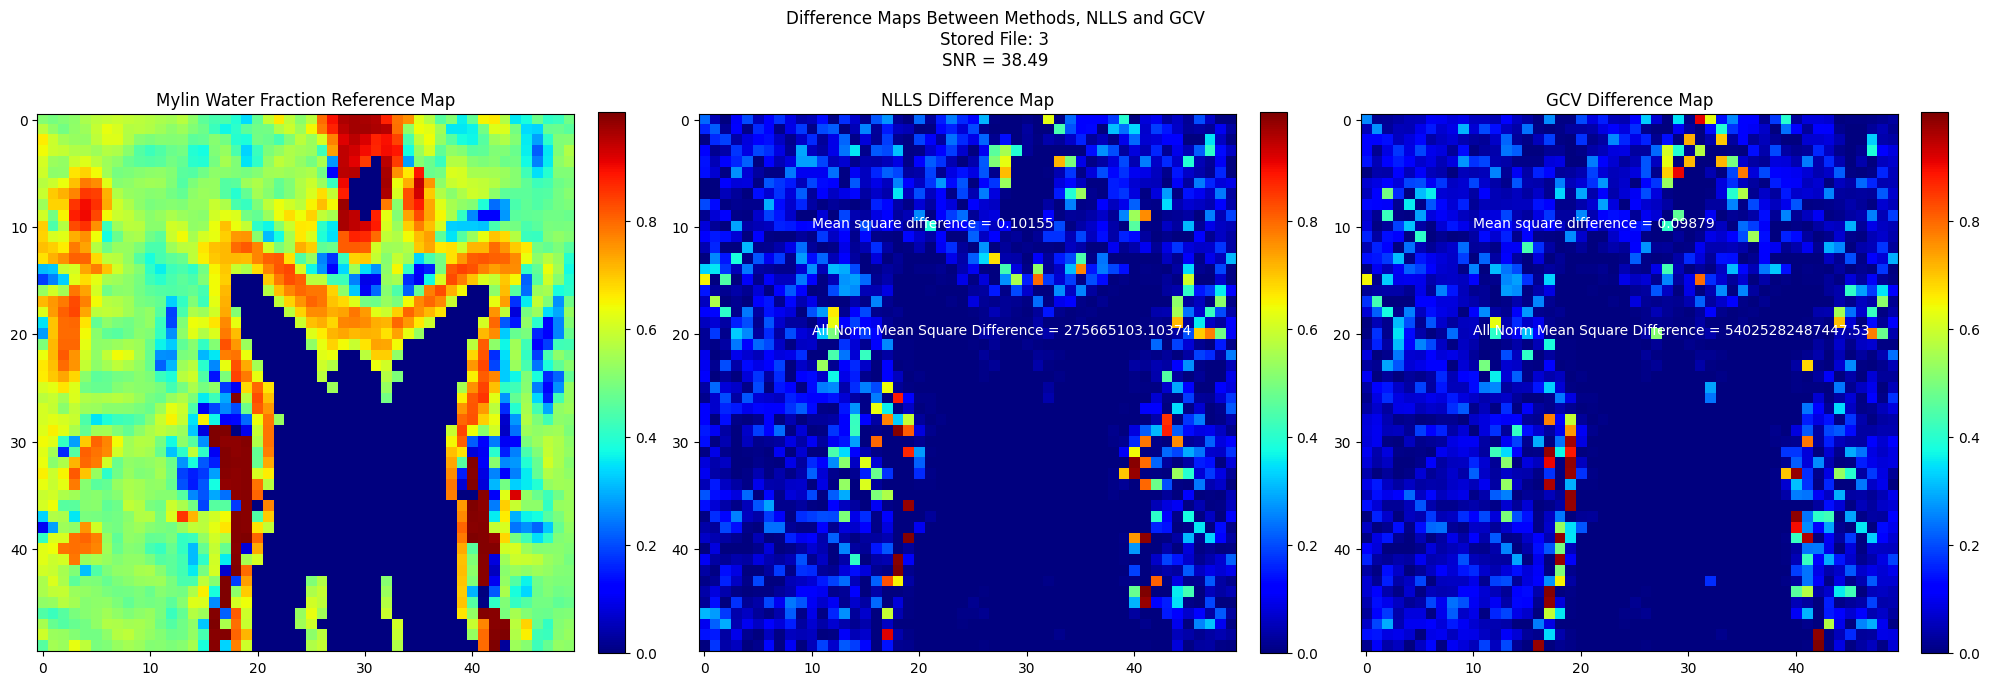

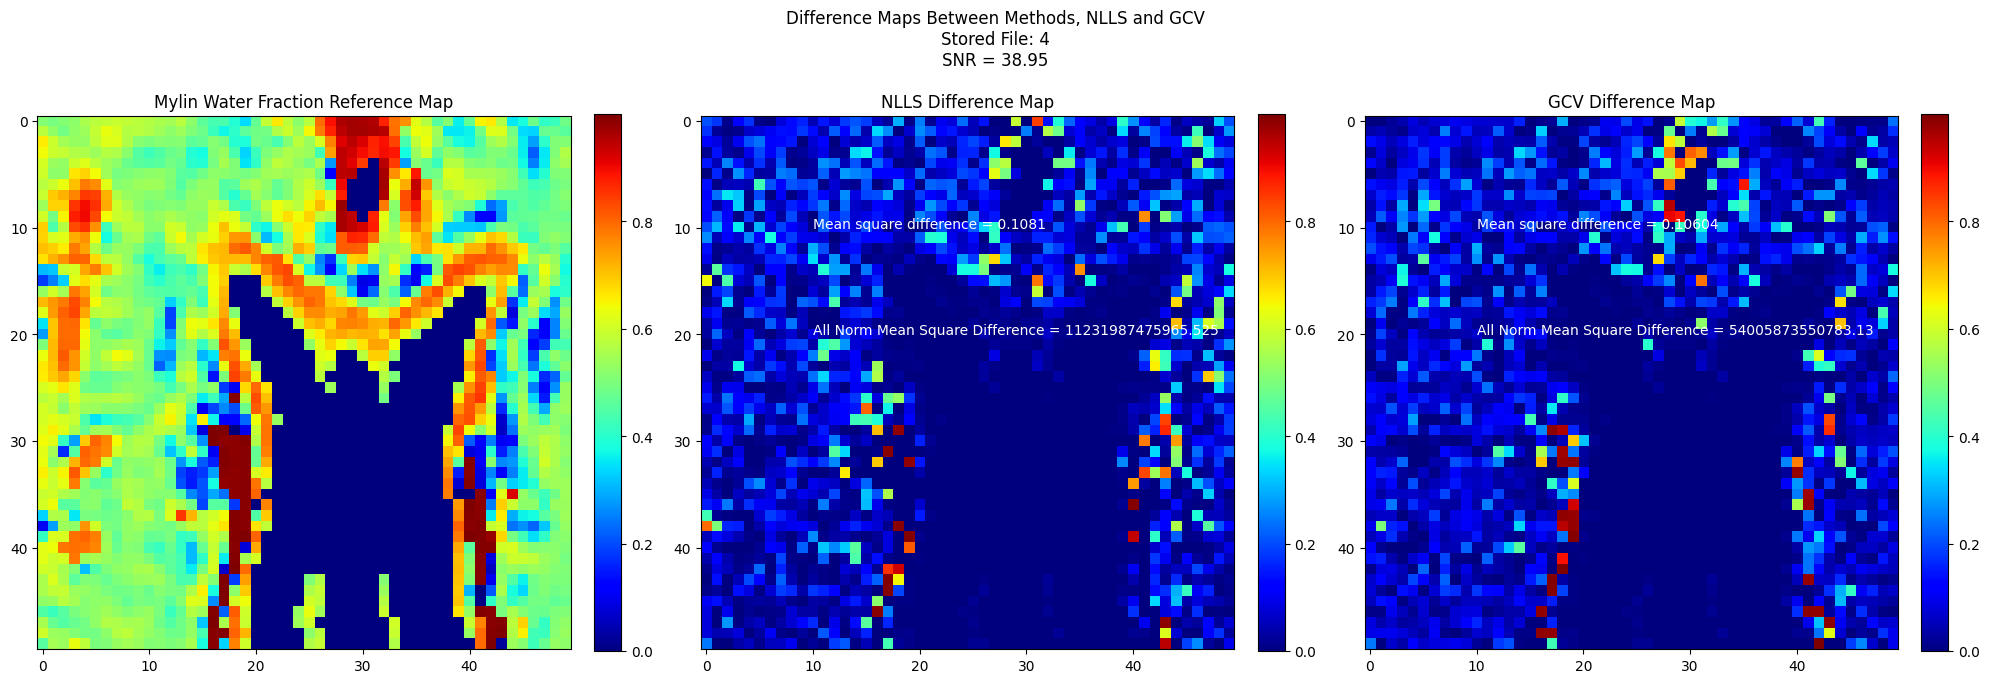

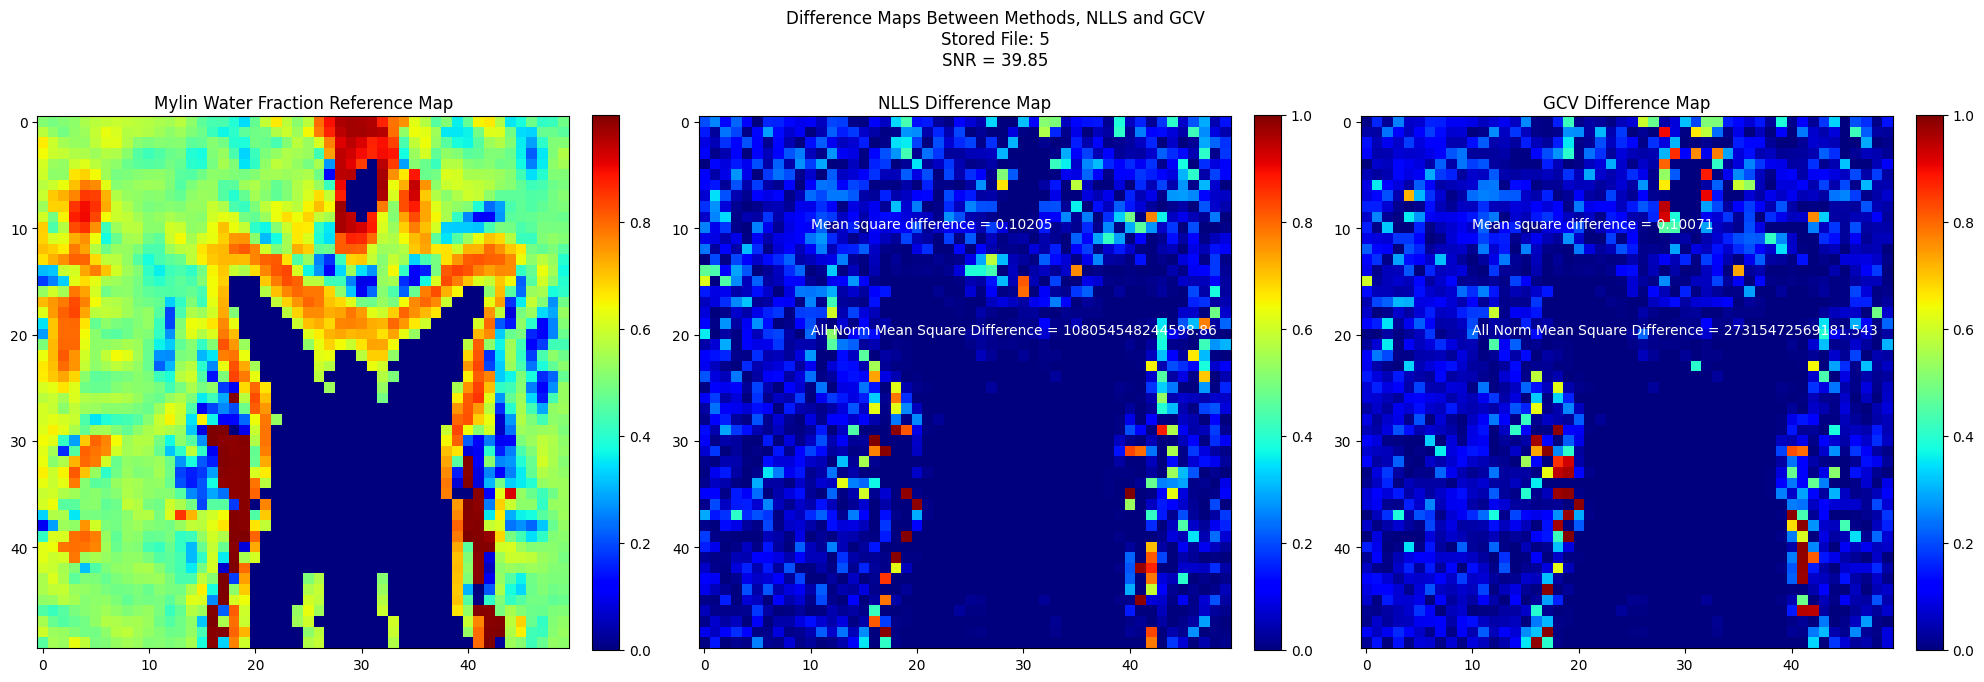

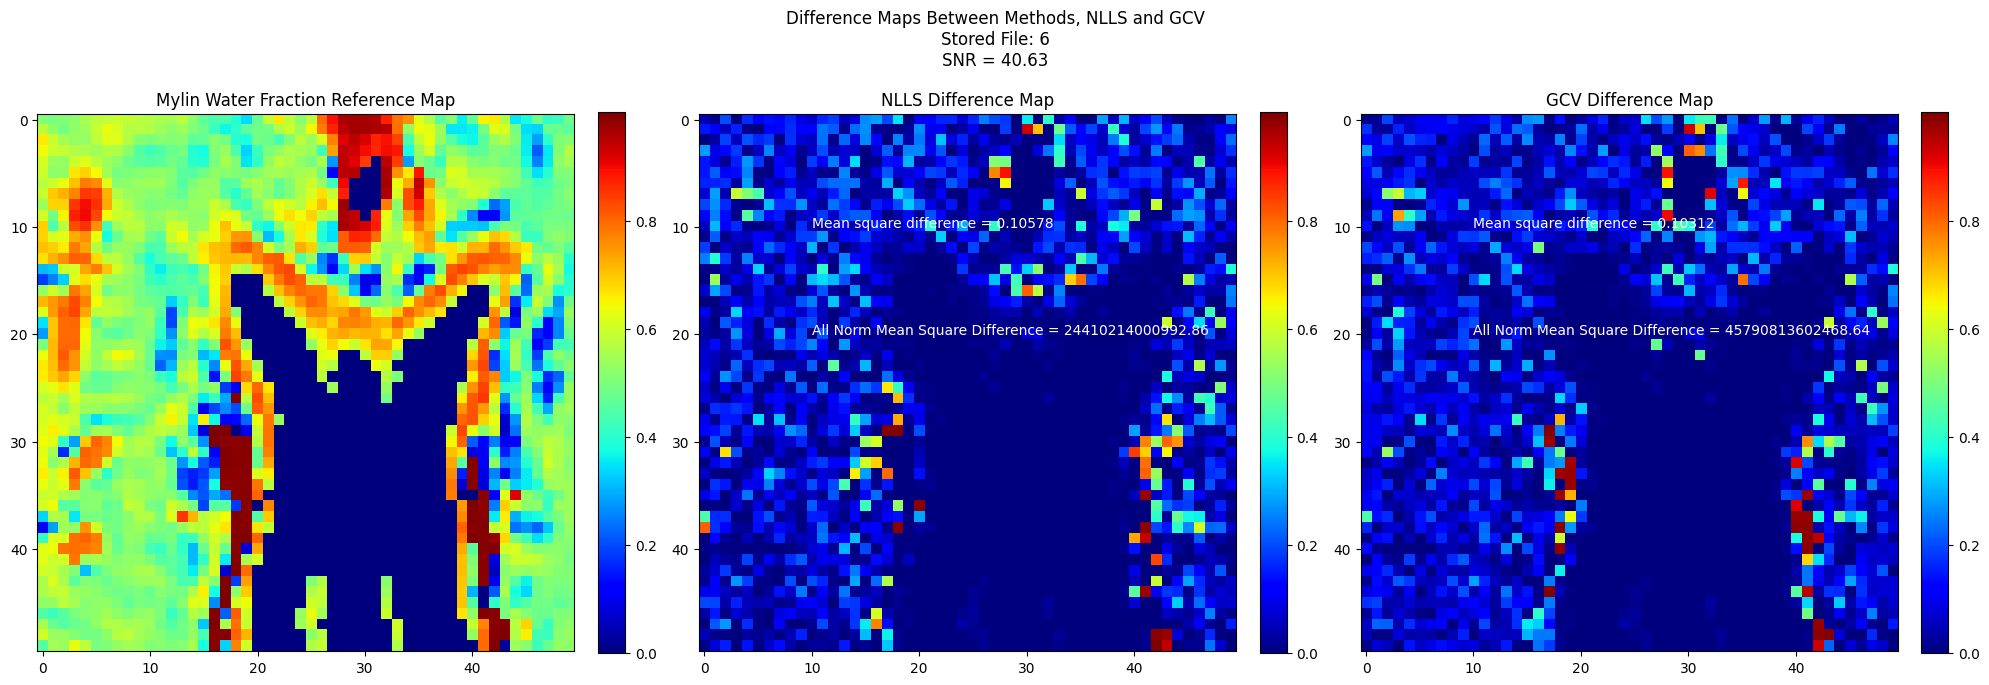

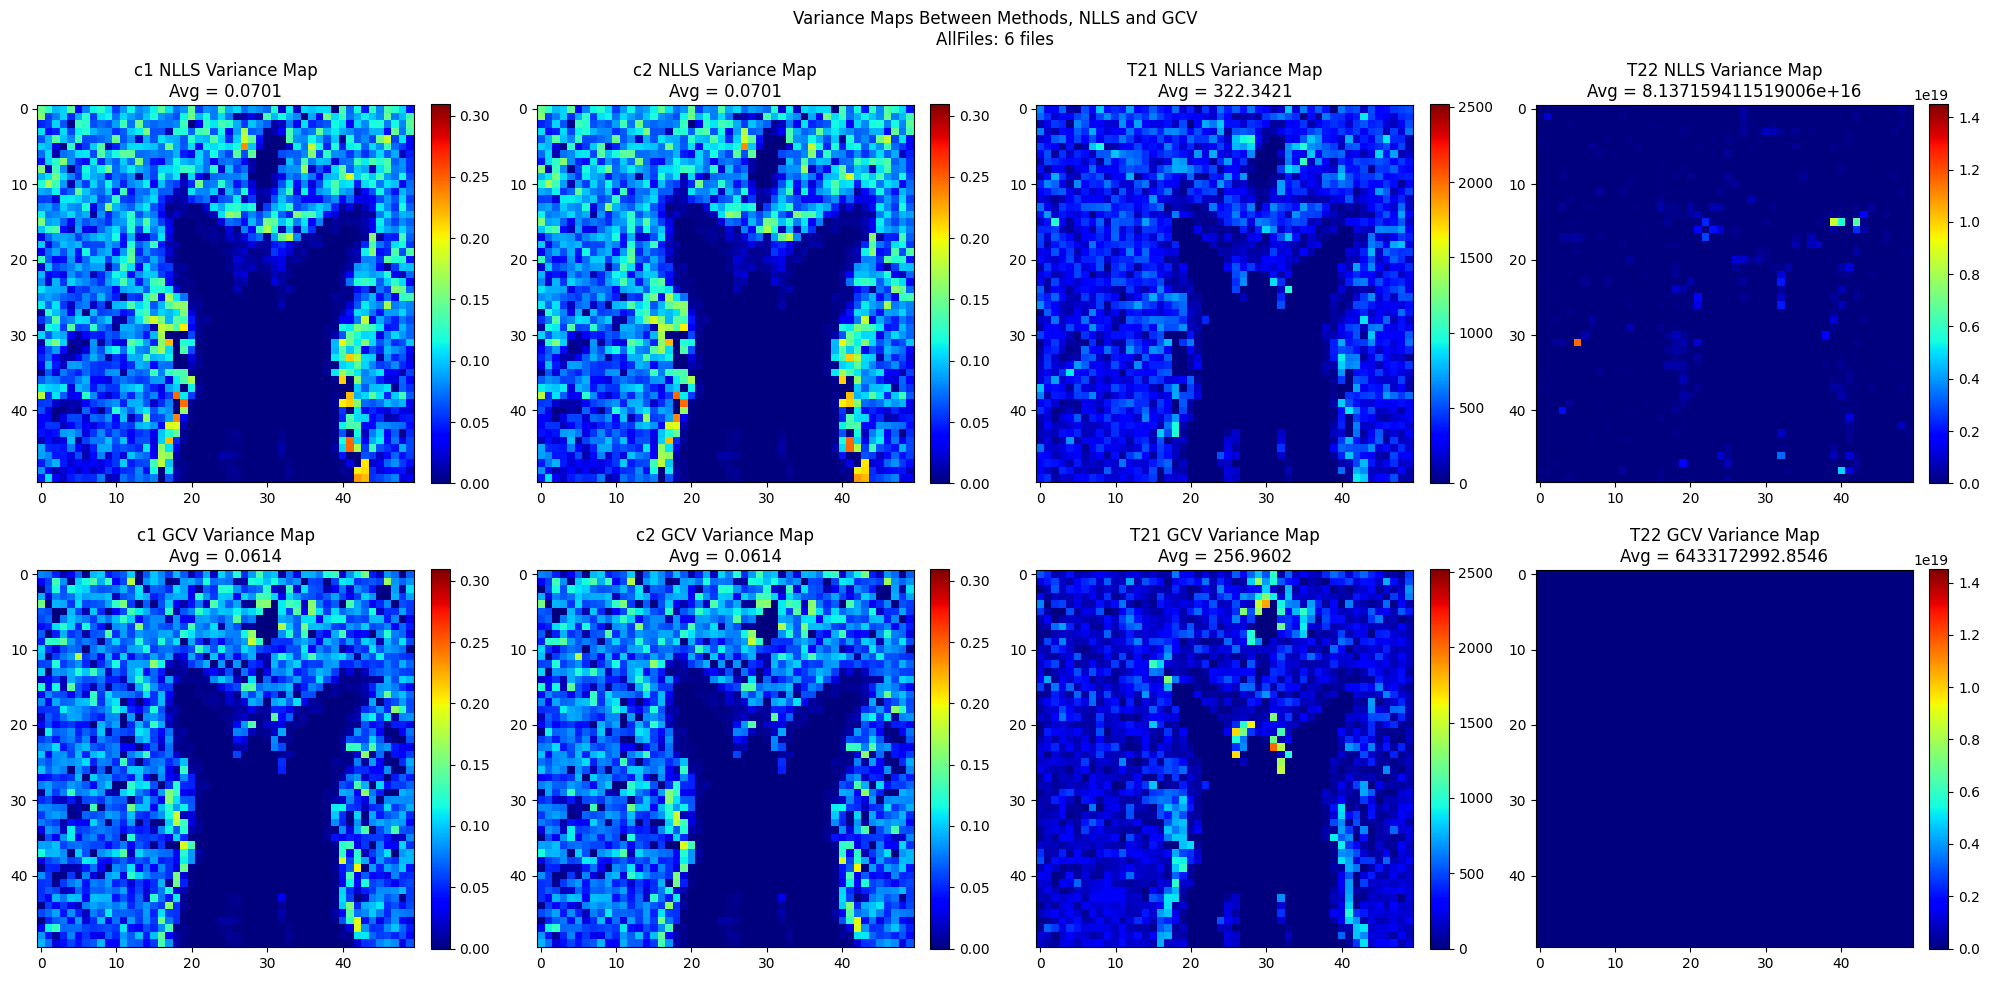

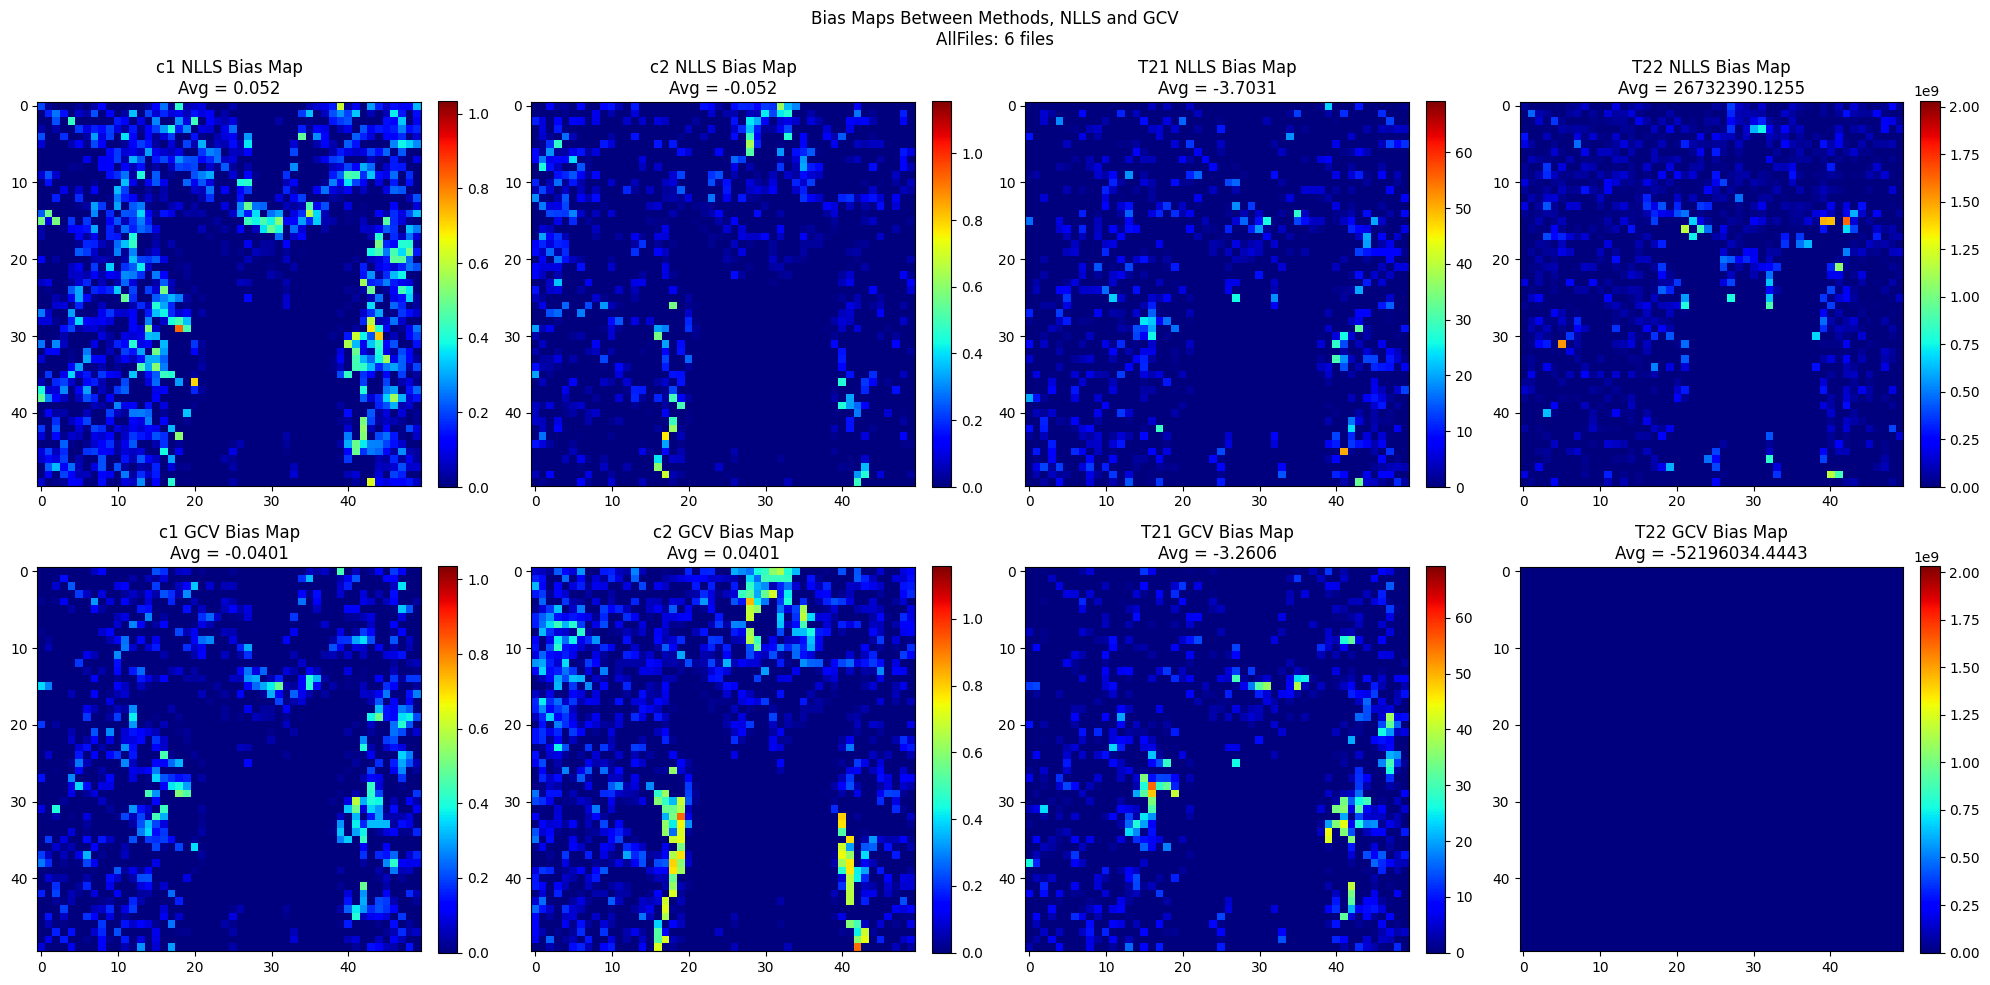

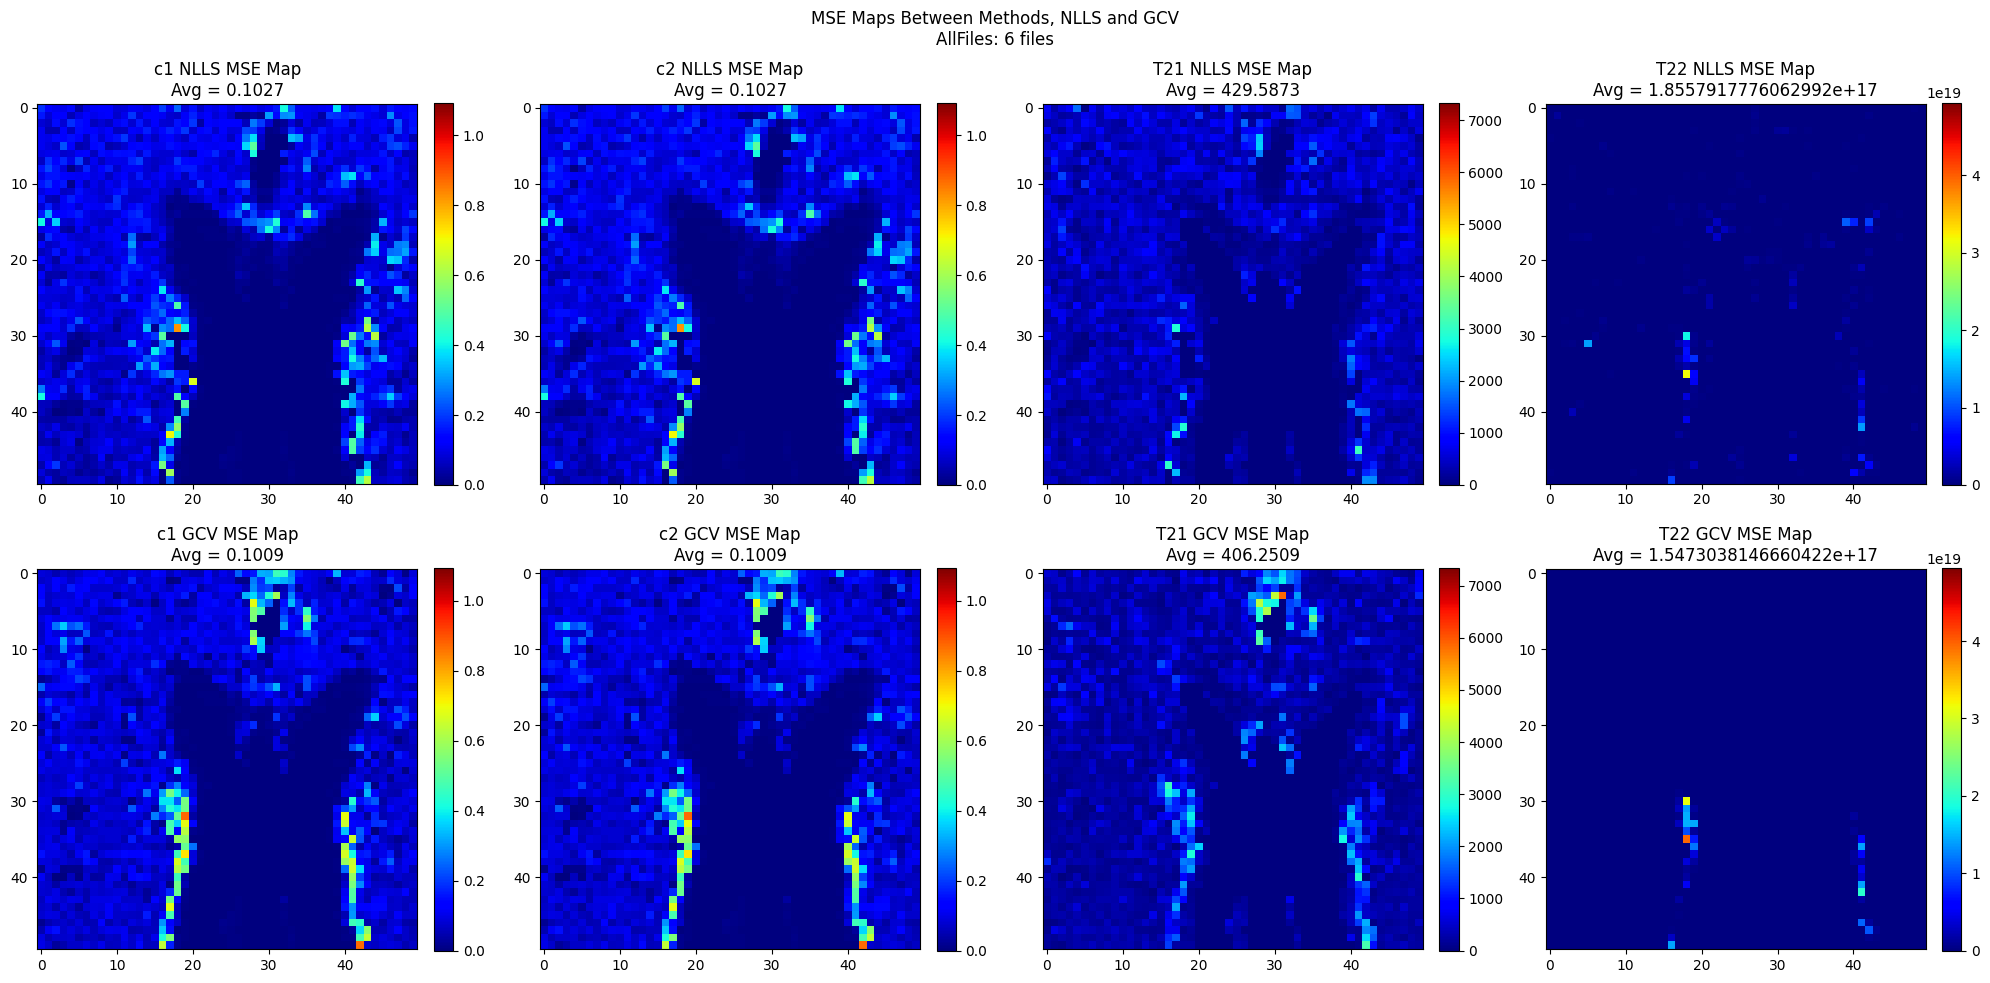

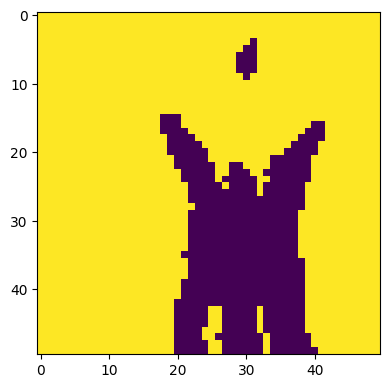

In [ ]:
from cmath import nan


numFiles = 6

paramStore_NLLS = np.zeros([n_hori,n_vert, 4*numFiles])
paramStore_NLLS = np.reshape(paramStore_NLLS, (n_hori,n_vert,4,numFiles))

paramStore_GCV = np.zeros([n_hori,n_vert,4*numFiles])
paramStore_GCV = np.reshape(paramStore_GCV, (n_hori,n_vert,4,numFiles))
# lambdaStore_GCV = np.zeros(n_hori,n_vert,numFiles)

for fi in range(numFiles):

    fileName = "unBound_subS_uSNR_12Oct22_40" + "_Rep_" + str(fi+1)

    with h5py.File('Brain_Repo//' + fileName +'.hdf5','a') as f:
        parameter_maps_NLLS = np.array(f['NLLS_params'])
        parameter_maps_GCV = np.array(f['GCV_params'])
        try:
            noised_data = np.array(f['Noised_data'])
            SNR_iter = calculate_brain_SNR(noised_data,noiseRegion)
        except:
            SNR_iter = nan
            print("No SNR available")

        

    paramStore_NLLS[:,:,:,fi] = parameter_maps_NLLS
    paramStore_GCV[:,:,:,fi] = parameter_maps_GCV

    NLLS_diff = (paramStore_NLLS[:,:,0,fi] - c1_ref)**2
    GCV_diff = (paramStore_GCV[:,:,0,fi] - c1_ref)**2

    NLLS_MSD = calculate_MSD(c1_ref, paramStore_NLLS[:,:,0,fi])
    GCV_MSD = calculate_MSD(c1_ref, paramStore_GCV[:,:,0,fi])

    NLLS_MSD_map, NLLS_MSD_norm = calculate_MSD_norm(brain_ref,paramStore_NLLS[:,:,:,fi])
    GCV_MSD_map, GCV_MSD_norm = calculate_MSD_norm(brain_ref,paramStore_GCV[:,:,:,fi])

    NLLS_MSD_total = 0
    GCV_MSD_total = 0
    for p in range(np.size(initial_brain)): #loops through parameters of the initial brain
        NLLS_MSD_total += calculate_MSD(brain_ref[:,:,p],paramStore_NLLS[:,:,p,fi])/initial_brain[p]
        GCV_MSD_total += calculate_MSD(brain_ref[:,:,p],paramStore_GCV[:,:,p,fi])/initial_brain[p]

    fig, ax = plt.subplots(1,3,figsize=(20,7),tight_layout=True)
    fig.suptitle('Difference Maps Between Methods, NLLS and GCV' + '\nStored File: '+ str(fi+1) + '\nSNR = ' + str(np.round(SNR_iter,2)))
    imref = ax[0].imshow(c1_ref, cmap = 'jet')
    ax[0].set_title('Mylin Water Fraction Reference Map')

    imNLLS = ax[1].imshow(NLLS_diff, cmap = 'jet', vmin=0, vmax=np.max([NLLS_diff,GCV_diff]))
    ax[1].set_title('NLLS Difference Map')
    ax[1].text(10, 10, 'Mean square difference = %s'%round(NLLS_MSD,5), color='w')
    # ax[1].text(10, 20, 'All Param Mean Square Difference = %s'%round(NLLS_MSD_total,5), color='w')
    ax[1].text(10, 20, 'All Norm Mean Square Difference = %s'%round(NLLS_MSD_norm,5), color='w')
    imGCV = ax[2].imshow(GCV_diff, cmap = 'jet', vmin=0, vmax=np.max([NLLS_diff,GCV_diff]))
    ax[2].set_title('GCV Difference Map')
    ax[2].text(10, 10, 'Mean square difference = %s'%round(GCV_MSD,5), color='w')
    # ax[2].text(10, 20, 'All Param Mean Square Difference = %s'%round(GCV_MSD_total,5), color='w')
    ax[2].text(10, 20, 'All Norm Mean Square Difference = %s'%round(GCV_MSD_norm,5), color='w')

    fig.colorbar(imref,ax=ax[0],fraction=0.046, pad=0.04)
    fig.colorbar(imNLLS,ax=ax[1],fraction=0.046, pad=0.04)
    fig.colorbar(imGCV,ax=ax[2],fraction=0.046, pad=0.04)
    plt.show()


#Standard Deviation Figures

varMap_NLLS = np.var(paramStore_NLLS, axis = 3)
varMap_GCV = np.var(paramStore_GCV, axis = 3)
paramList = ("c1", "c2", "T21", "T22")

fig, ax = plt.subplots(2,4,figsize=(20,10),tight_layout=True)
fig.suptitle('Variance Maps Between Methods, NLLS and GCV' + '\nAllFiles: ' + str(numFiles) + " files")
for i in range(4):
    pNLLS = ax[0,i].imshow(varMap_NLLS[:,:,i], cmap = 'jet', vmin=0, vmax=1.25*np.max([varMap_NLLS[:,:,i],varMap_GCV[:,:,i]]))
    fig.colorbar(pNLLS,ax=ax[0,i], fraction=0.046, pad=0.04)
    ax[0,i].set_title(paramList[i] + ' NLLS Variance Map' + '\nAvg = ' + str(round(np.mean(varMap_NLLS[:,:,i][c1_ref!=0]),4)))

    pGCV = ax[1,i].imshow(varMap_GCV[:,:,i], cmap = 'jet', vmin=0, vmax=1.25*np.max([varMap_NLLS[:,:,i],varMap_GCV[:,:,i]]))
    fig.colorbar(pGCV,ax=ax[1,i], fraction=0.046, pad=0.04)
    ax[1,i].set_title(paramList[i] + ' GCV Variance Map' + '\nAvg = ' + str(round(np.mean(varMap_GCV[:,:,i][c1_ref!=0]),4)))

#Bias Figures

bMap_NLLS = np.mean(paramStore_NLLS, axis = 3) - brain_ref
bMap_GCV = np.mean(paramStore_GCV, axis = 3) - brain_ref
paramList = ("c1", "c2", "T21", "T22")

fig, ax = plt.subplots(2,4,figsize=(20,10),tight_layout=True)
fig.suptitle('Bias Maps Between Methods, NLLS and GCV' + '\nAllFiles: ' + str(numFiles) + " files")
for i in range(4):
    pNLLS = ax[0,i].imshow(bMap_NLLS[:,:,i], cmap = 'jet', vmin=0, vmax=1.25*np.max([bMap_NLLS[:,:,i],bMap_GCV[:,:,i]]))
    fig.colorbar(pNLLS,ax=ax[0,i], fraction=0.046, pad=0.04)
    ax[0,i].set_title(paramList[i] + ' NLLS Bias Map' + '\nAvg = ' + str(round(np.mean(bMap_NLLS[:,:,i][c1_ref!=0]),4)))

    pGCV = ax[1,i].imshow(bMap_GCV[:,:,i], cmap = 'jet', vmin=0, vmax=1.25*np.max([bMap_NLLS[:,:,i],bMap_GCV[:,:,i]]))
    fig.colorbar(pGCV,ax=ax[1,i], fraction=0.046, pad=0.04)
    ax[1,i].set_title(paramList[i] + ' GCV Bias Map' + '\nAvg = ' + str(round(np.mean(bMap_GCV[:,:,i][c1_ref!=0]),4)))

#MSE Figures

MSEMap_NLLS = varMap_NLLS + bMap_NLLS**2
MSEMap_GCV = varMap_GCV + bMap_GCV**2
paramList = ("c1", "c2", "T21", "T22")

fig, ax = plt.subplots(2,4,figsize=(20,10),tight_layout=True)
fig.suptitle('MSE Maps Between Methods, NLLS and GCV' + '\nAllFiles: ' + str(numFiles) + " files")
for i in range(4):
    pNLLS = ax[0,i].imshow(MSEMap_NLLS[:,:,i], cmap = 'jet', vmin=0, vmax=1.25*np.max([MSEMap_NLLS[:,:,i],MSEMap_GCV[:,:,i]]))
    fig.colorbar(pNLLS,ax=ax[0,i], fraction=0.046, pad=0.04)
    ax[0,i].set_title(paramList[i] + ' NLLS MSE Map' + '\nAvg = ' + str(round(np.mean(MSEMap_NLLS[:,:,i][c1_ref!=0]),4)))

    pGCV = ax[1,i].imshow(MSEMap_GCV[:,:,i], cmap = 'jet', vmin=0, vmax=1.25*np.max([MSEMap_NLLS[:,:,i],MSEMap_GCV[:,:,i]]))
    fig.colorbar(pGCV,ax=ax[1,i], fraction=0.046, pad=0.04)
    ax[1,i].set_title(paramList[i] + ' GCV MSE Map' + '\nAvg = ' + str(round(np.mean(MSEMap_GCV[:,:,i][c1_ref!=0]),4)))

fig = plt.figure(figsize = (4,4), tight_layout=True )
plt.imshow(c1_ref!=0)

        

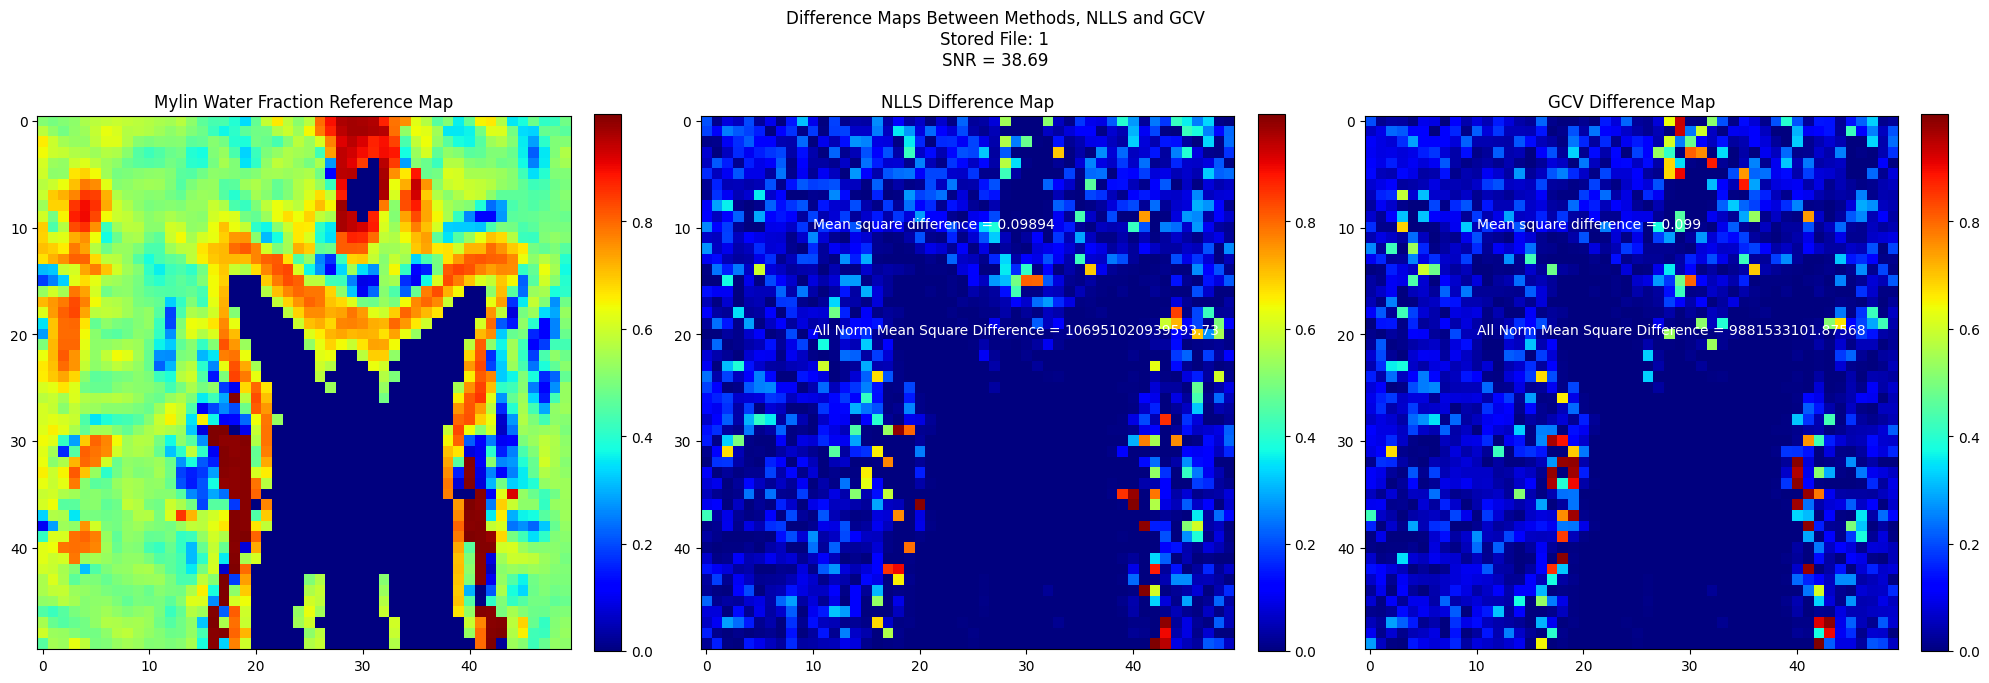

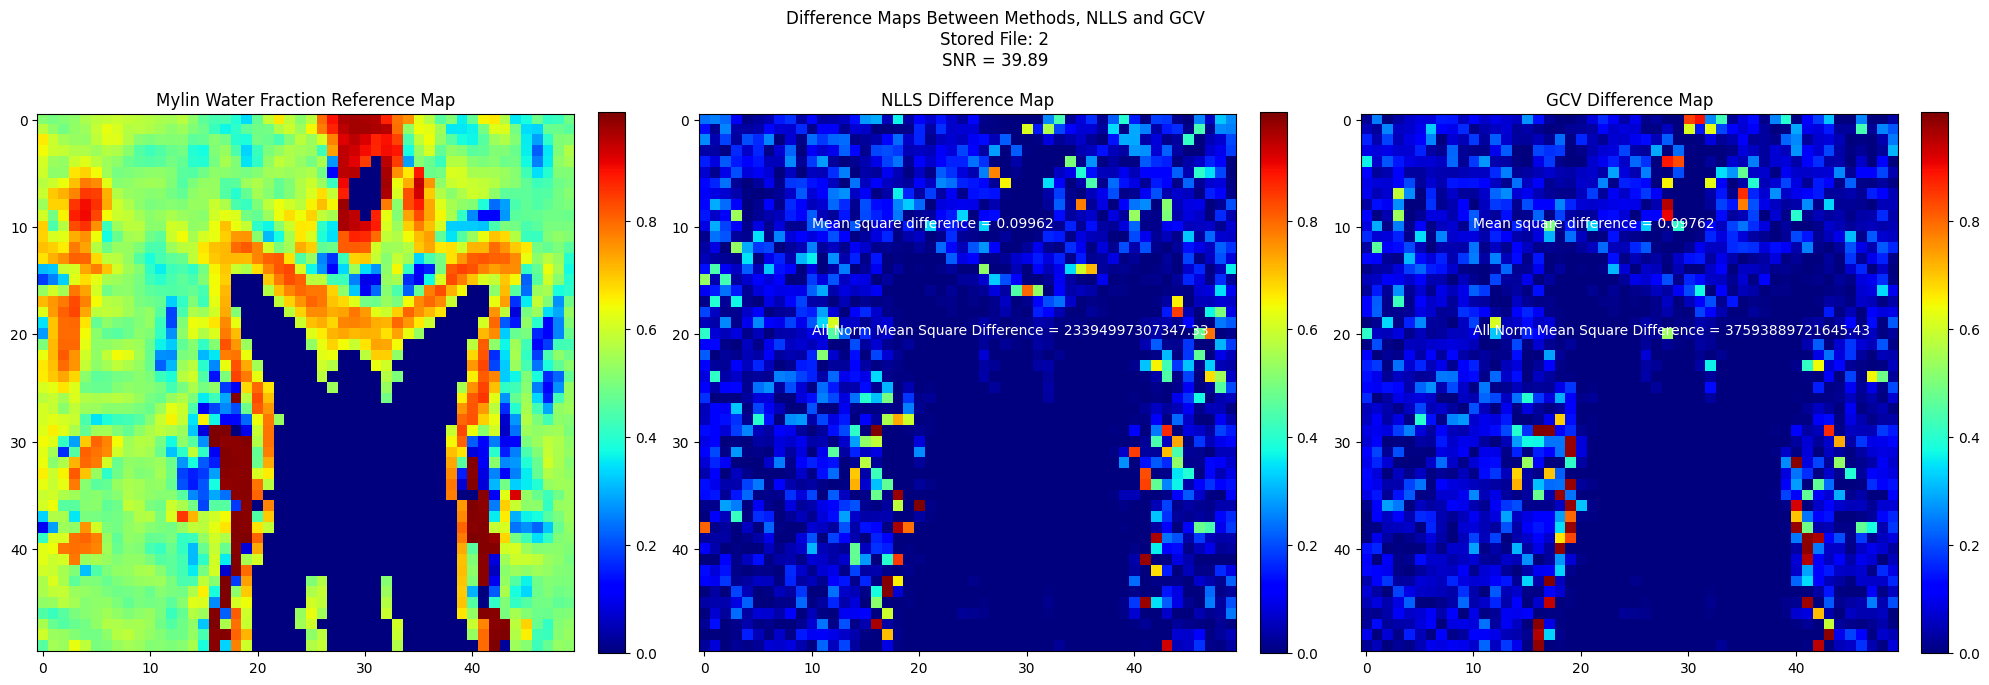

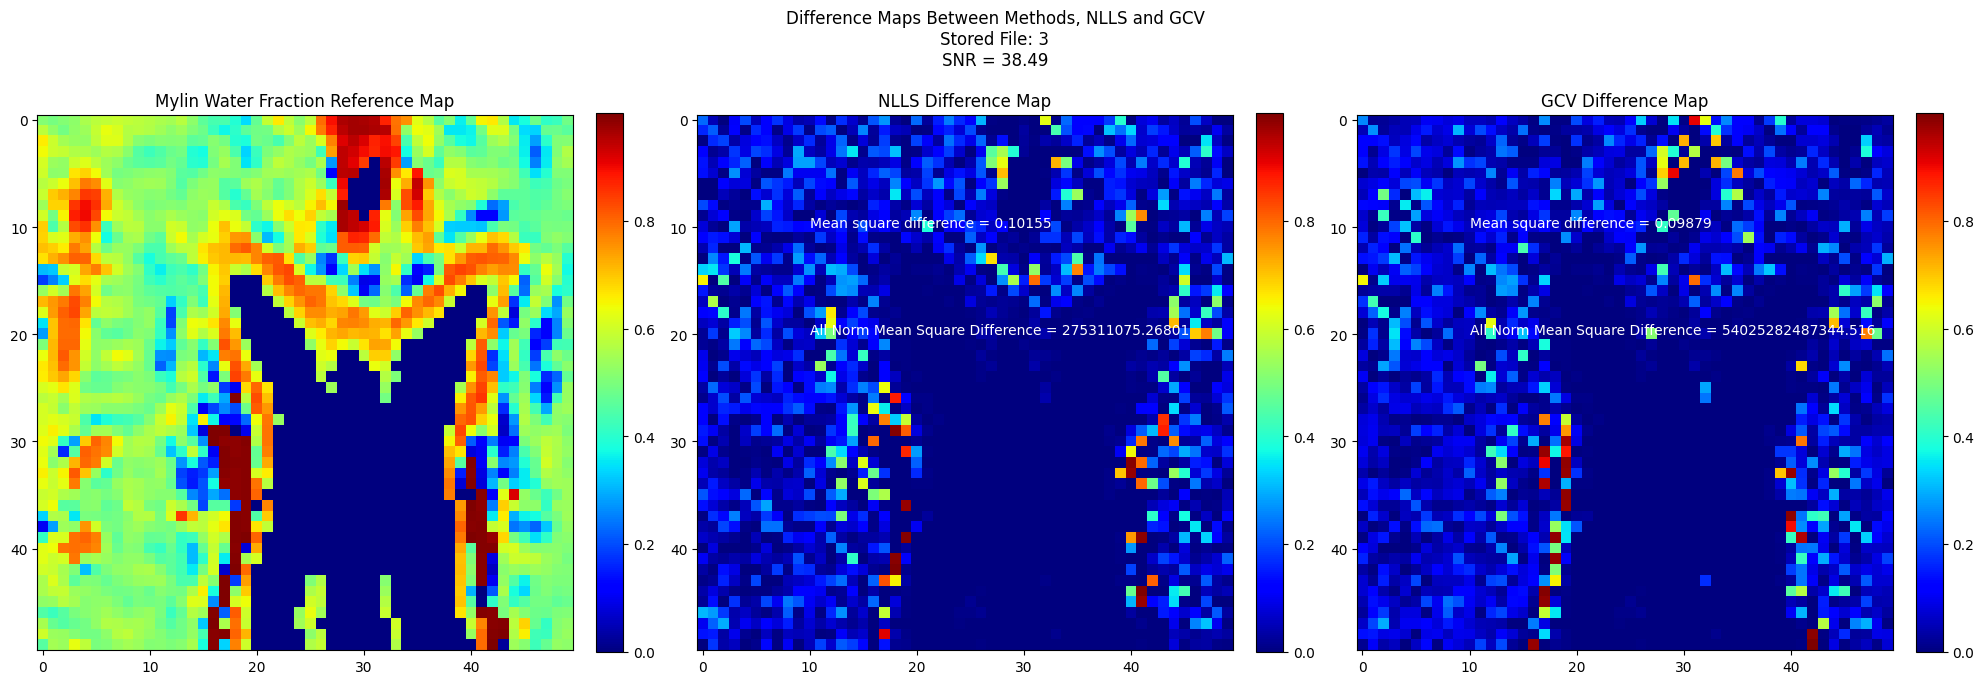

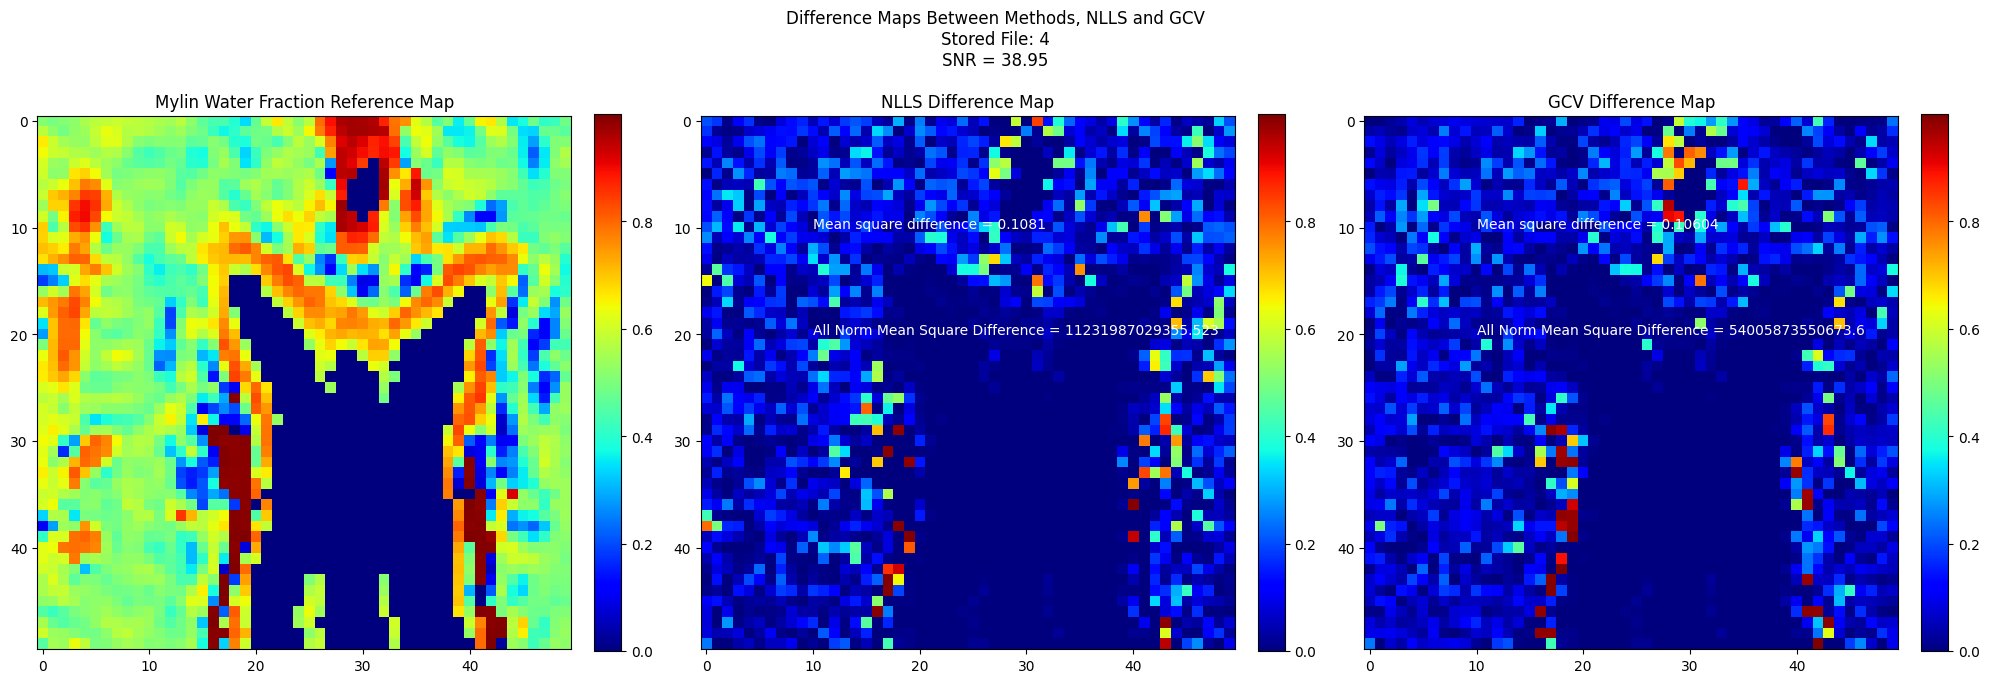

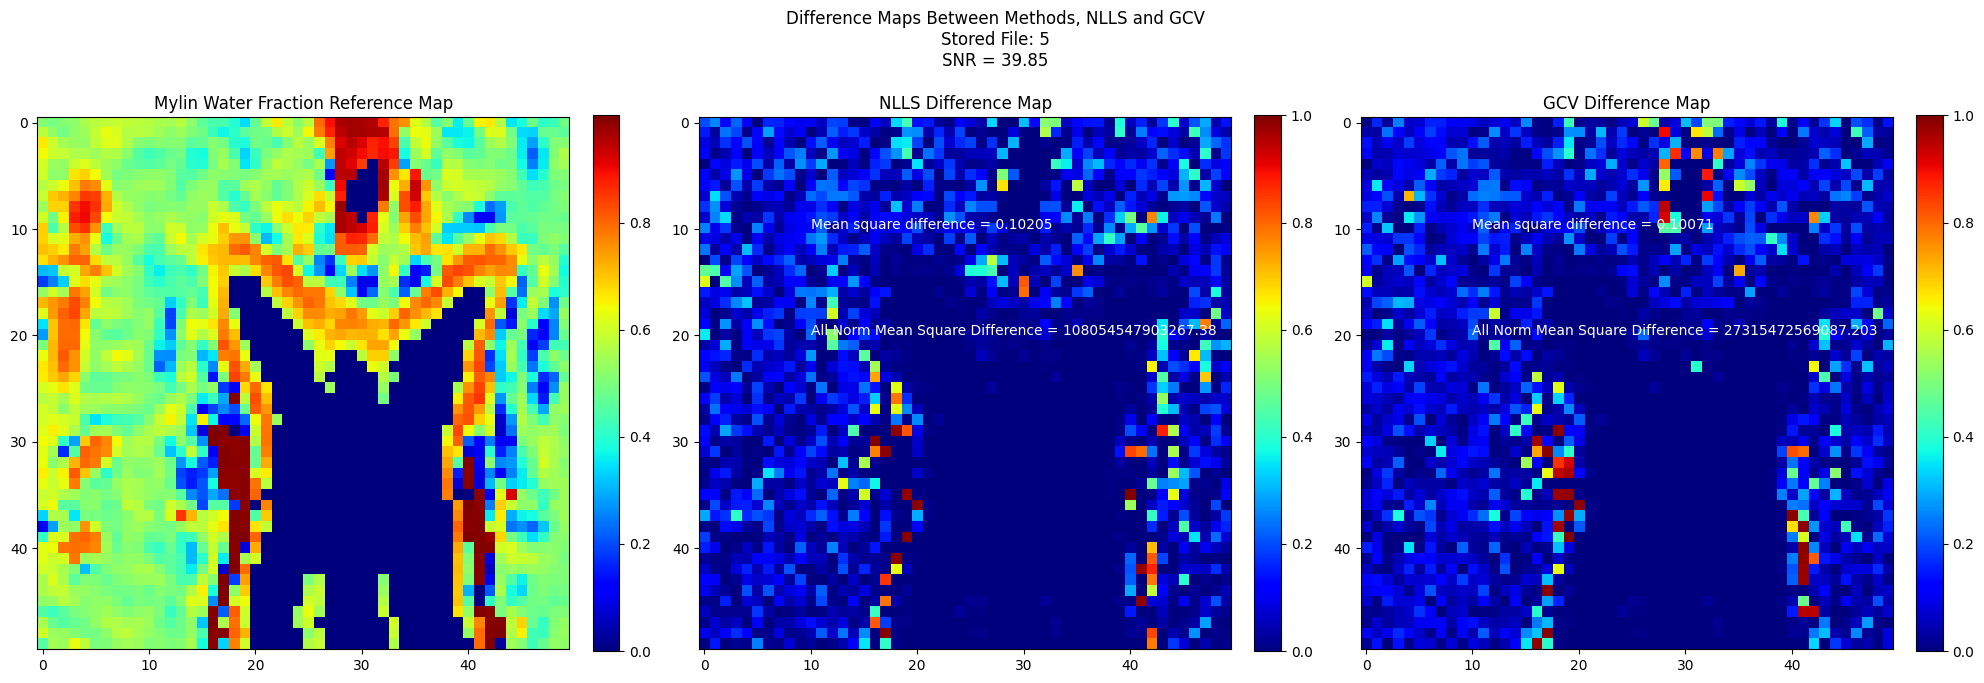

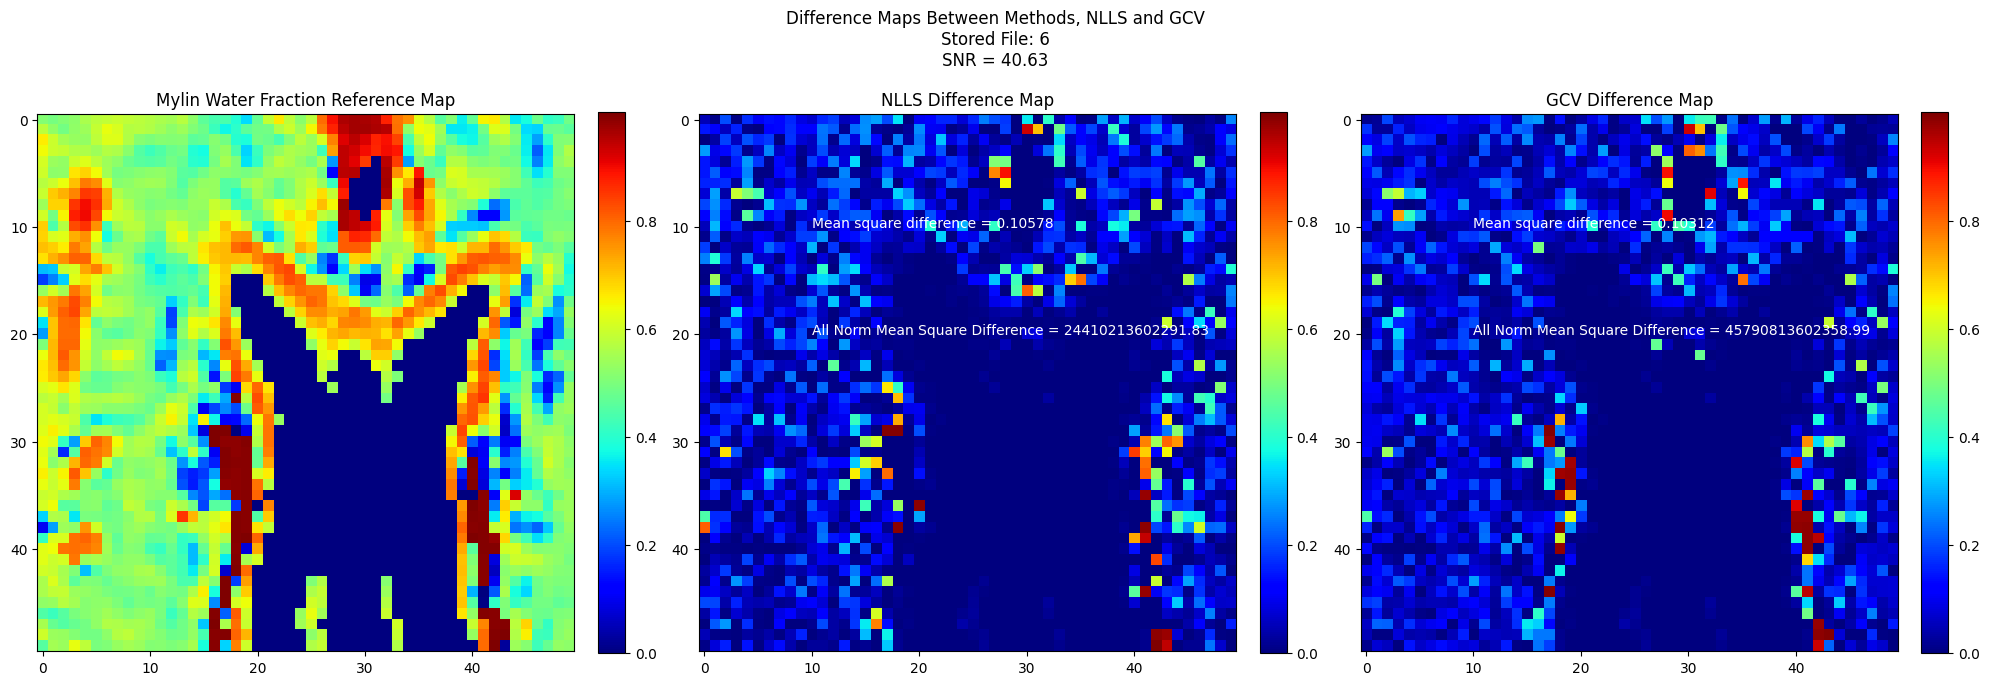

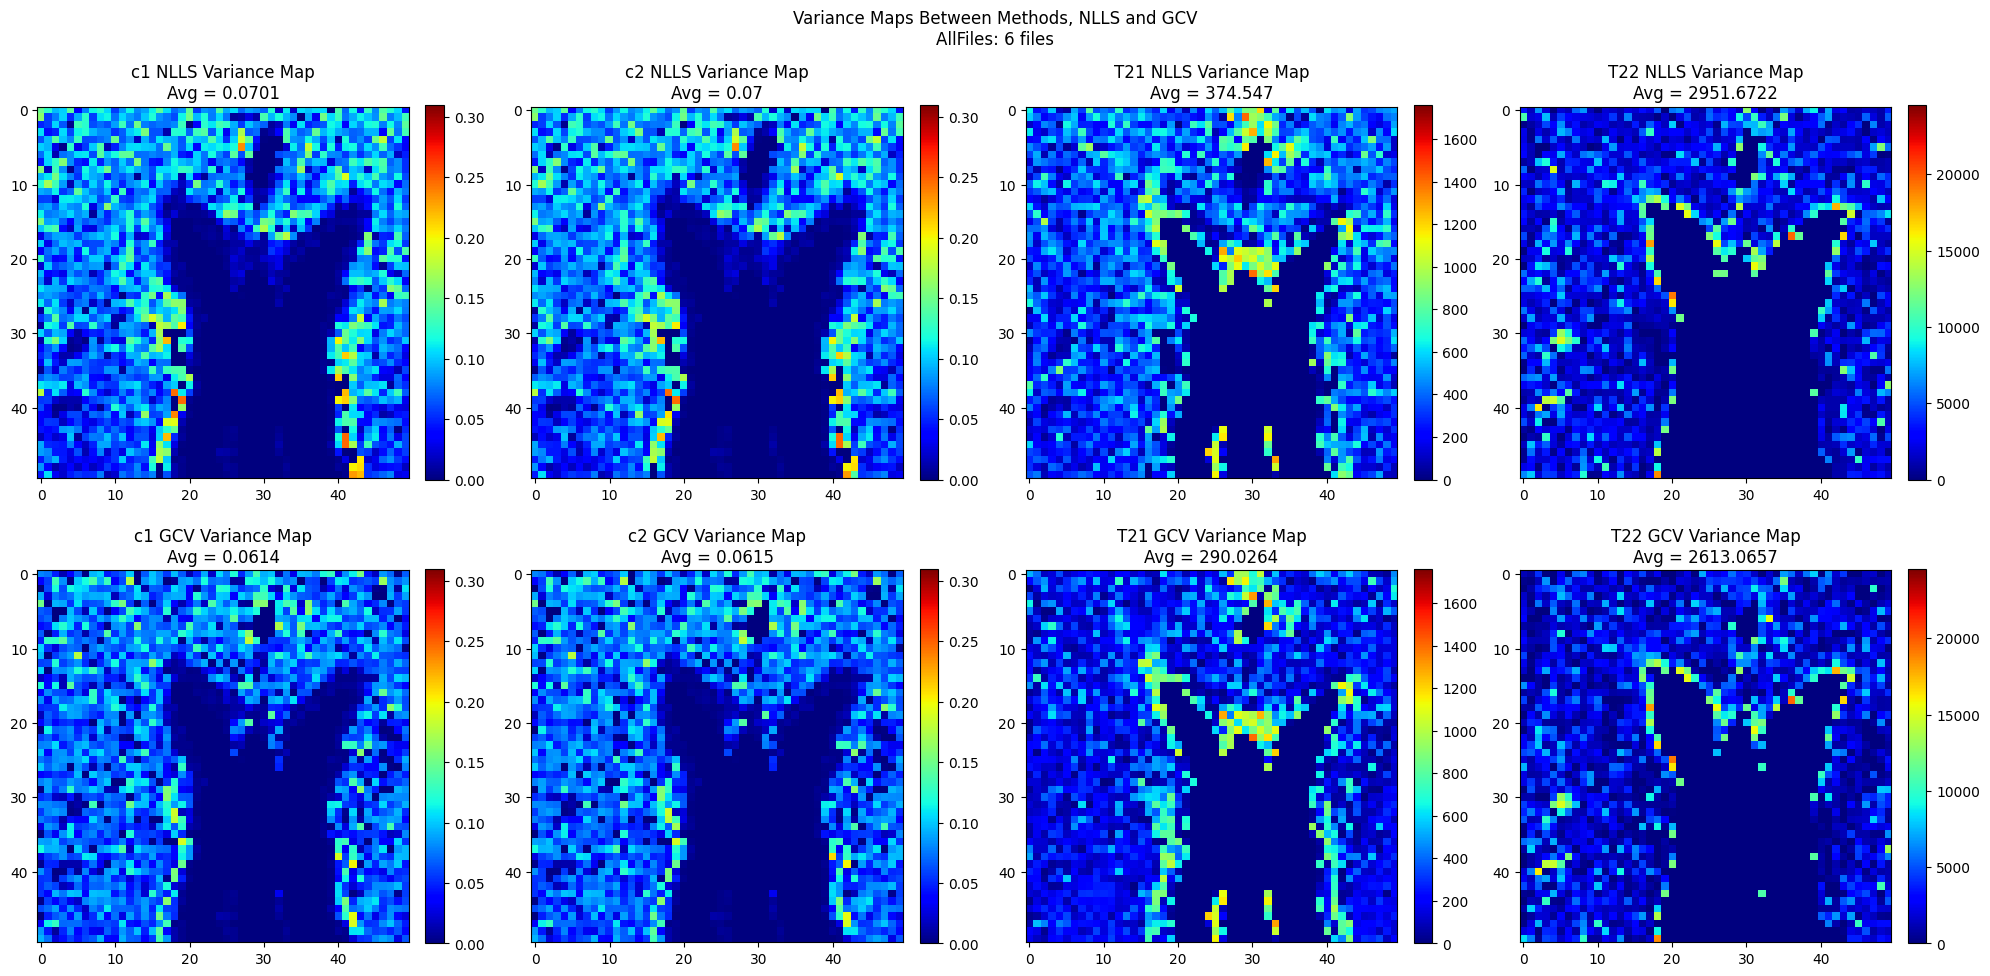

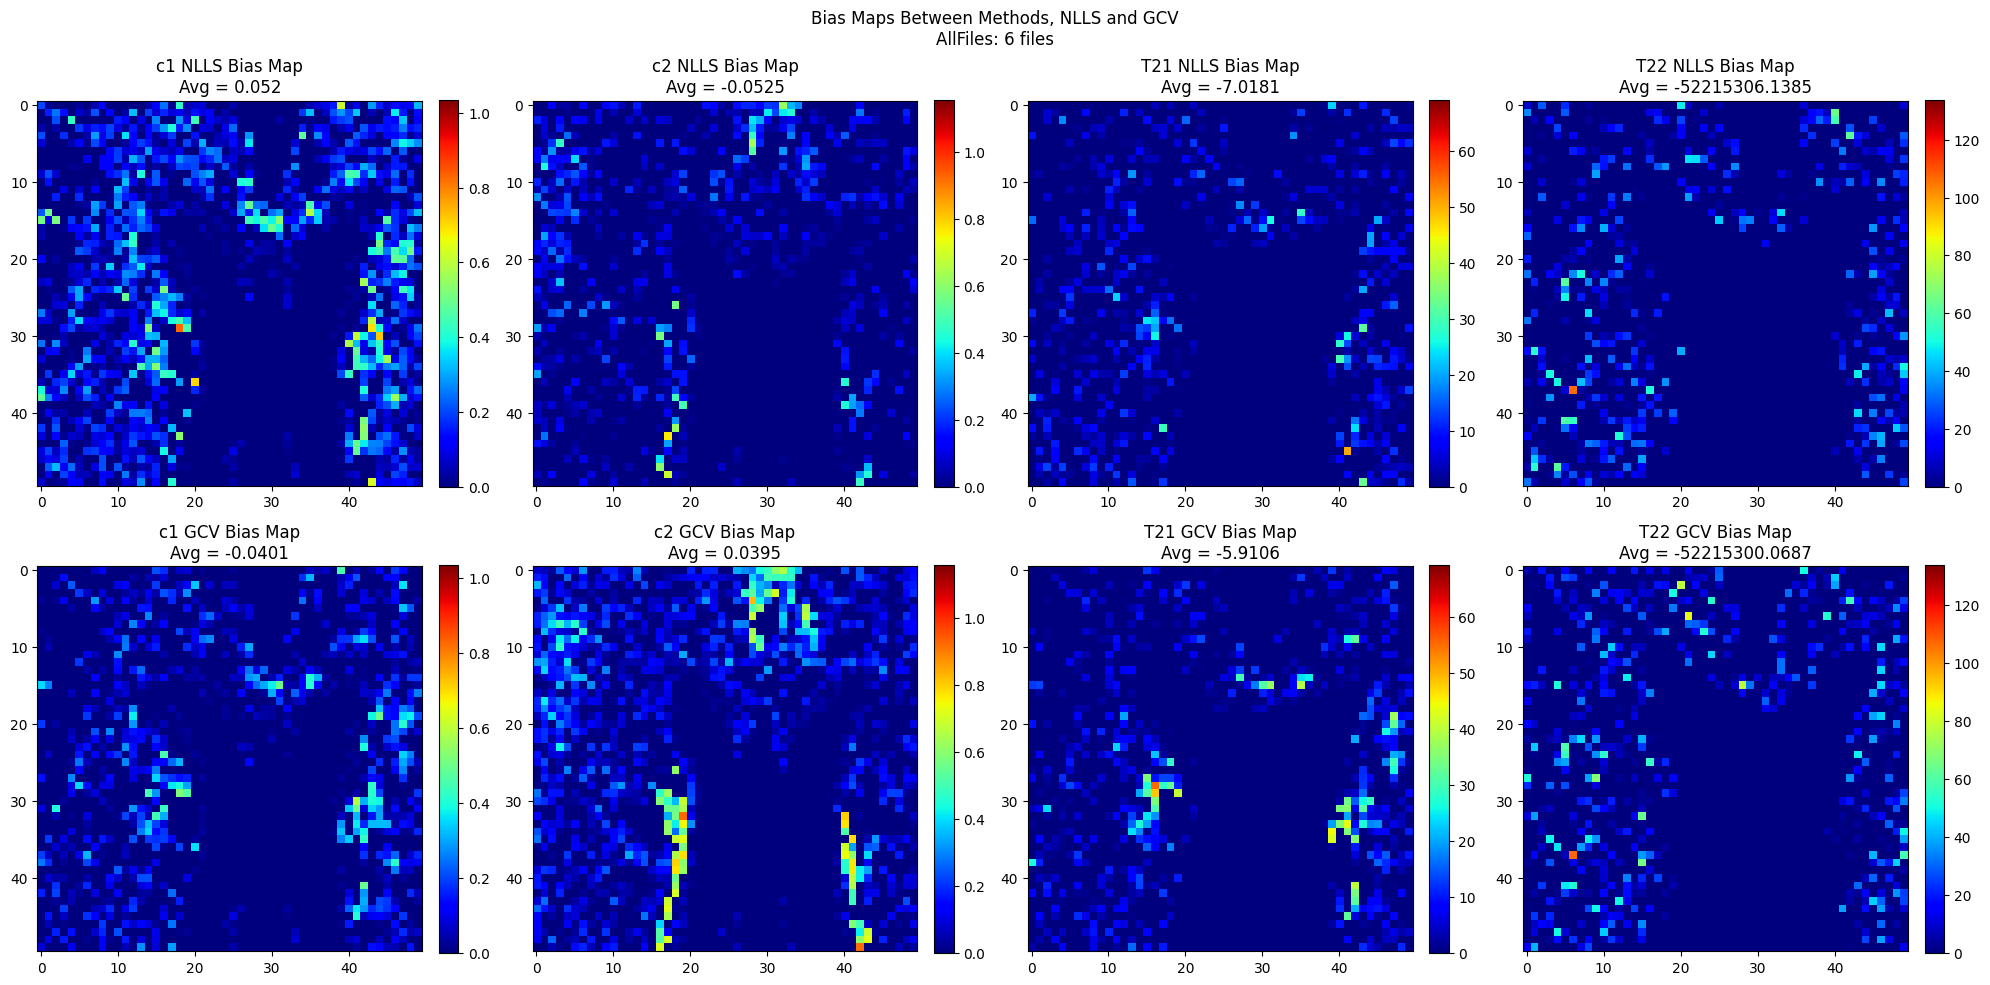

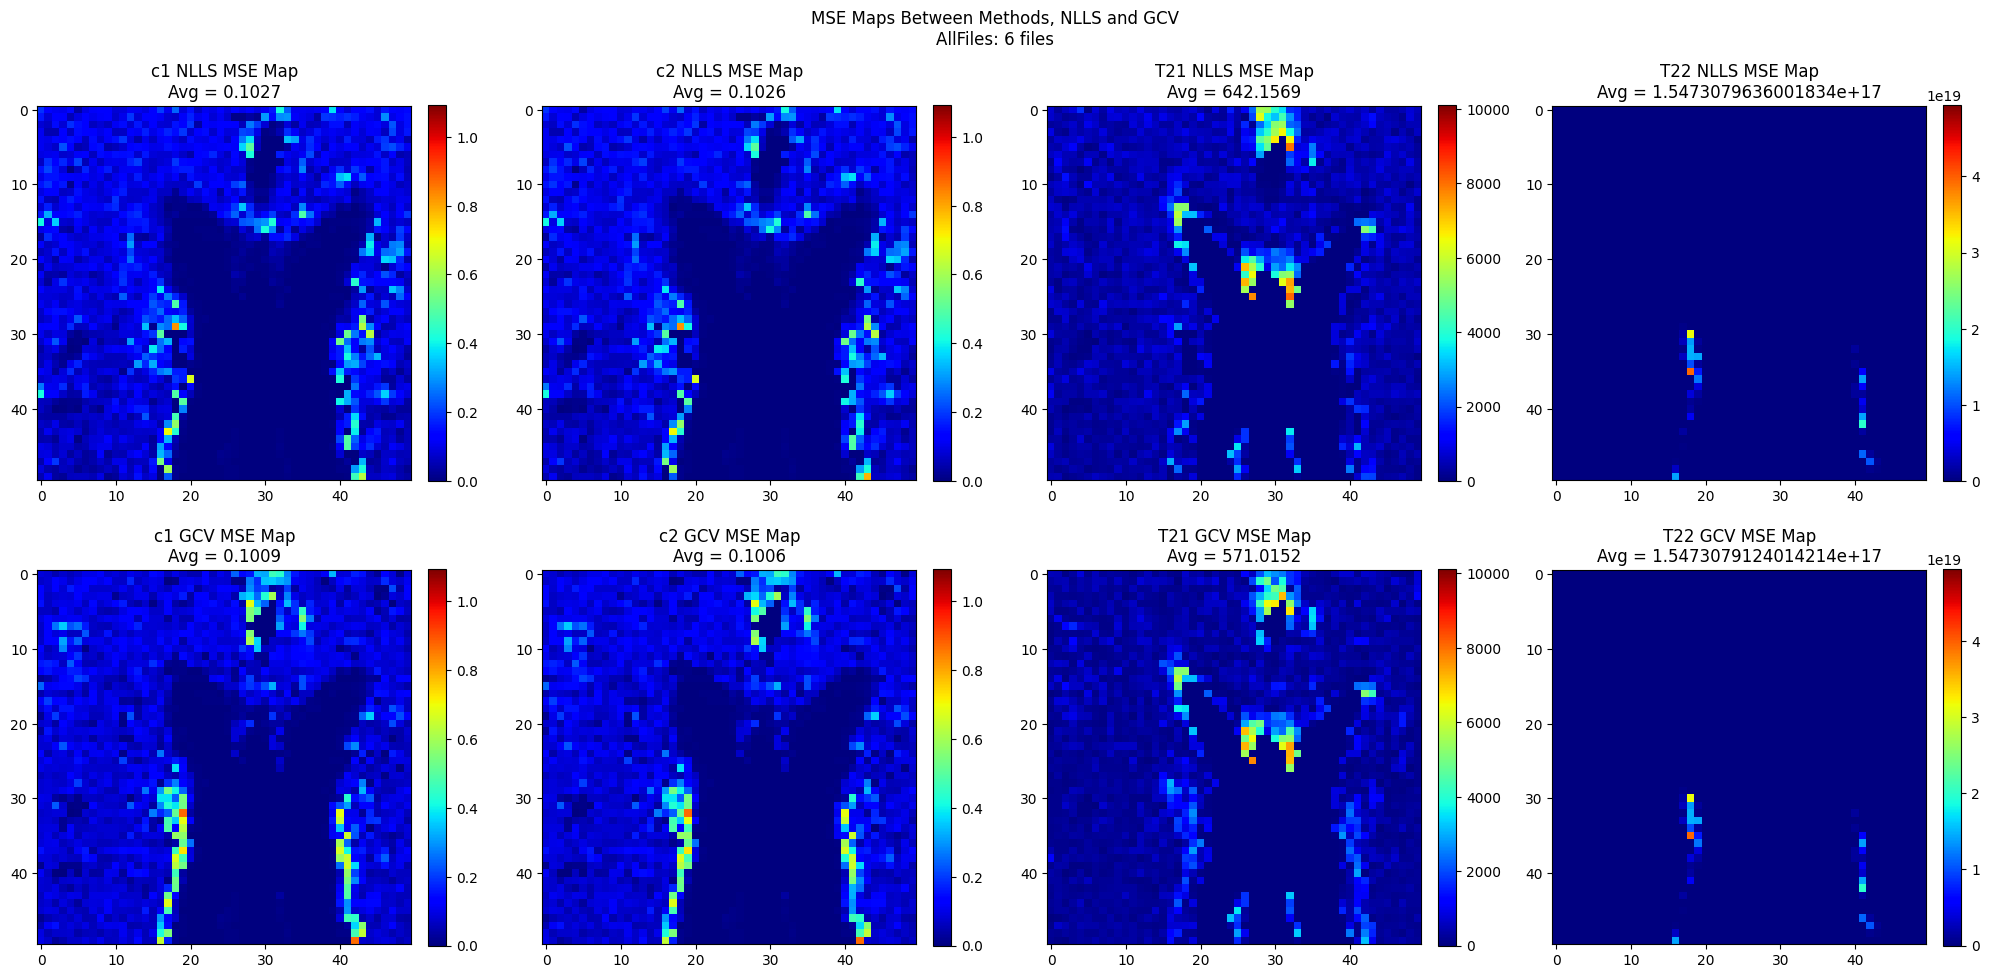

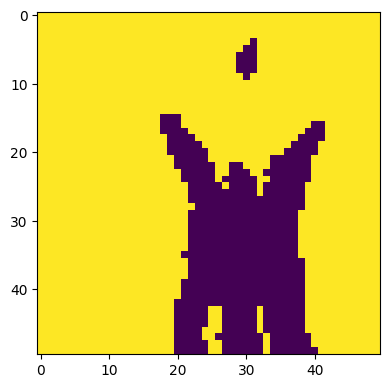

In [ ]:
if not bounded:
    from cmath import nan


    numFiles = 6

    paramStore_NLLS = np.zeros([n_hori,n_vert, 4*numFiles])
    paramStore_NLLS = np.reshape(paramStore_NLLS, (n_hori,n_vert,4,numFiles))

    paramStore_GCV = np.zeros([n_hori,n_vert,4*numFiles])
    paramStore_GCV = np.reshape(paramStore_GCV, (n_hori,n_vert,4,numFiles))
    # lambdaStore_GCV = np.zeros(n_hori,n_vert,numFiles)

    for fi in range(numFiles):

        fileName = "unBound_subS_uSNR_12Oct22_40" + "_Rep_" + str(fi+1)

        with h5py.File('Brain_Repo//' + fileName +'.hdf5','a') as f:
            parameter_maps_NLLS = np.array(f['NLLS_params'])
            parameter_maps_GCV = np.array(f['GCV_params'])
            try:
                noised_data = np.array(f['Noised_data'])
                SNR_iter = calculate_brain_SNR(noised_data,noiseRegion)
            except:
                SNR_iter = nan
                print("No SNR available")

            

        paramStore_NLLS[:,:,:,fi] = parameter_maps_NLLS
        for iter in range(paramStore_NLLS[:,:,:,fi].shape[-1]):
            hold = paramStore_NLLS[:,:,iter,fi]
            outlier_count[iter] = np.sum(hold>upper_bound_reasonable[iter])
            paramStore_NLLS[:,:,iter,fi] = hold*(hold<upper_bound_reasonable[iter])
        paramStore_GCV[:,:,:,fi] = parameter_maps_GCV
        for iter in range(paramStore_GCV[:,:,:,fi].shape[-1]):
            hold = paramStore_GCV[:,:,iter,fi]
            outlier_count[iter] = np.sum(hold>upper_bound_reasonable[iter])
            paramStore_GCV[:,:,iter,fi] = hold*(hold<upper_bound_reasonable[iter])

        NLLS_diff = (paramStore_NLLS[:,:,0,fi] - c1_ref)**2
        GCV_diff = (paramStore_GCV[:,:,0,fi] - c1_ref)**2

        NLLS_MSD = calculate_MSD(c1_ref, paramStore_NLLS[:,:,0,fi])
        GCV_MSD = calculate_MSD(c1_ref, paramStore_GCV[:,:,0,fi])

        NLLS_MSD_map, NLLS_MSD_norm = calculate_MSD_norm(brain_ref,paramStore_NLLS[:,:,:,fi])
        GCV_MSD_map, GCV_MSD_norm = calculate_MSD_norm(brain_ref,paramStore_GCV[:,:,:,fi])

        NLLS_MSD_total = 0
        GCV_MSD_total = 0
        for p in range(np.size(initial_brain)): #loops through parameters of the initial brain
            NLLS_MSD_total += calculate_MSD(brain_ref[:,:,p],paramStore_NLLS[:,:,p,fi])/initial_brain[p]
            GCV_MSD_total += calculate_MSD(brain_ref[:,:,p],paramStore_GCV[:,:,p,fi])/initial_brain[p]

        fig, ax = plt.subplots(1,3,figsize=(20,7),tight_layout=True)
        fig.suptitle('Difference Maps Between Methods, NLLS and GCV' + '\nStored File: '+ str(fi+1) + '\nSNR = ' + str(np.round(SNR_iter,2)))
        imref = ax[0].imshow(c1_ref, cmap = 'jet')
        ax[0].set_title('Mylin Water Fraction Reference Map')

        imNLLS = ax[1].imshow(NLLS_diff, cmap = 'jet', vmin=0, vmax=np.max([NLLS_diff,GCV_diff]))
        ax[1].set_title('NLLS Difference Map')
        ax[1].text(10, 10, 'Mean square difference = %s'%round(NLLS_MSD,5), color='w')
        # ax[1].text(10, 20, 'All Param Mean Square Difference = %s'%round(NLLS_MSD_total,5), color='w')
        ax[1].text(10, 20, 'All Norm Mean Square Difference = %s'%round(NLLS_MSD_norm,5), color='w')
        imGCV = ax[2].imshow(GCV_diff, cmap = 'jet', vmin=0, vmax=np.max([NLLS_diff,GCV_diff]))
        ax[2].set_title('GCV Difference Map')
        ax[2].text(10, 10, 'Mean square difference = %s'%round(GCV_MSD,5), color='w')
        # ax[2].text(10, 20, 'All Param Mean Square Difference = %s'%round(GCV_MSD_total,5), color='w')
        ax[2].text(10, 20, 'All Norm Mean Square Difference = %s'%round(GCV_MSD_norm,5), color='w')

        fig.colorbar(imref,ax=ax[0],fraction=0.046, pad=0.04)
        fig.colorbar(imNLLS,ax=ax[1],fraction=0.046, pad=0.04)
        fig.colorbar(imGCV,ax=ax[2],fraction=0.046, pad=0.04)
        plt.show()


    #Standard Deviation Figures

    varMap_NLLS = np.var(paramStore_NLLS, axis = 3)
    varMap_GCV = np.var(paramStore_GCV, axis = 3)
    paramList = ("c1", "c2", "T21", "T22")

    fig, ax = plt.subplots(2,4,figsize=(20,10),tight_layout=True)
    fig.suptitle('Variance Maps Between Methods, NLLS and GCV' + '\nAllFiles: ' + str(numFiles) + " files")
    for i in range(4):
        pNLLS = ax[0,i].imshow(varMap_NLLS[:,:,i], cmap = 'jet', vmin=0, vmax=1.25*np.max([varMap_NLLS[:,:,i],varMap_GCV[:,:,i]]))
        fig.colorbar(pNLLS,ax=ax[0,i], fraction=0.046, pad=0.04)
        ax[0,i].set_title(paramList[i] + ' NLLS Variance Map' + '\nAvg = ' + str(round(np.mean(varMap_NLLS[:,:,i][c1_ref!=0]),4)))

        pGCV = ax[1,i].imshow(varMap_GCV[:,:,i], cmap = 'jet', vmin=0, vmax=1.25*np.max([varMap_NLLS[:,:,i],varMap_GCV[:,:,i]]))
        fig.colorbar(pGCV,ax=ax[1,i], fraction=0.046, pad=0.04)
        ax[1,i].set_title(paramList[i] + ' GCV Variance Map' + '\nAvg = ' + str(round(np.mean(varMap_GCV[:,:,i][c1_ref!=0]),4)))

    #Bias Figures

    bMap_NLLS = np.mean(paramStore_NLLS, axis = 3) - brain_ref
    bMap_GCV = np.mean(paramStore_GCV, axis = 3) - brain_ref
    paramList = ("c1", "c2", "T21", "T22")

    fig, ax = plt.subplots(2,4,figsize=(20,10),tight_layout=True)
    fig.suptitle('Bias Maps Between Methods, NLLS and GCV' + '\nAllFiles: ' + str(numFiles) + " files")
    for i in range(4):
        pNLLS = ax[0,i].imshow(bMap_NLLS[:,:,i], cmap = 'jet', vmin=0, vmax=1.25*np.max([bMap_NLLS[:,:,i],bMap_GCV[:,:,i]]))
        fig.colorbar(pNLLS,ax=ax[0,i], fraction=0.046, pad=0.04)
        ax[0,i].set_title(paramList[i] + ' NLLS Bias Map' + '\nAvg = ' + str(round(np.mean(bMap_NLLS[:,:,i][c1_ref!=0]),4)))

        pGCV = ax[1,i].imshow(bMap_GCV[:,:,i], cmap = 'jet', vmin=0, vmax=1.25*np.max([bMap_NLLS[:,:,i],bMap_GCV[:,:,i]]))
        fig.colorbar(pGCV,ax=ax[1,i], fraction=0.046, pad=0.04)
        ax[1,i].set_title(paramList[i] + ' GCV Bias Map' + '\nAvg = ' + str(round(np.mean(bMap_GCV[:,:,i][c1_ref!=0]),4)))

    #MSE Figures

    MSEMap_NLLS = varMap_NLLS + bMap_NLLS**2
    MSEMap_GCV = varMap_GCV + bMap_GCV**2
    paramList = ("c1", "c2", "T21", "T22")

    fig, ax = plt.subplots(2,4,figsize=(20,10),tight_layout=True)
    fig.suptitle('MSE Maps Between Methods, NLLS and GCV' + '\nAllFiles: ' + str(numFiles) + " files")
    for i in range(4):
        pNLLS = ax[0,i].imshow(MSEMap_NLLS[:,:,i], cmap = 'jet', vmin=0, vmax=1.25*np.max([MSEMap_NLLS[:,:,i],MSEMap_GCV[:,:,i]]))
        fig.colorbar(pNLLS,ax=ax[0,i], fraction=0.046, pad=0.04)
        ax[0,i].set_title(paramList[i] + ' NLLS MSE Map' + '\nAvg = ' + str(round(np.mean(MSEMap_NLLS[:,:,i][c1_ref!=0]),4)))

        pGCV = ax[1,i].imshow(MSEMap_GCV[:,:,i], cmap = 'jet', vmin=0, vmax=1.25*np.max([MSEMap_NLLS[:,:,i],MSEMap_GCV[:,:,i]]))
        fig.colorbar(pGCV,ax=ax[1,i], fraction=0.046, pad=0.04)
        ax[1,i].set_title(paramList[i] + ' GCV MSE Map' + '\nAvg = ' + str(round(np.mean(MSEMap_GCV[:,:,i][c1_ref!=0]),4)))

    fig = plt.figure(figsize = (4,4), tight_layout=True )
    plt.imshow(c1_ref!=0)

        